**Finding features of overperforming schools**

by Ben Lacar
A basic mission of our school system is to see that all students graduate high school and avoid dropping out. Students who drop out face significant life challenges, including lower wages and higher incarceration rates. However, the factors that influence a school's dropout rate are numerous and complex. The purpose of this data science project is to explore and identify features that could contribute prevent high dropout rate. Here, I focus on data for California public schools and local employment data. I aim to find features of overperforming school populations. I define this as a school's population that faces socio-economic difficulties, yet have low dropout rates.

In [3]:
# Import packages

# ------  Web Scraping --------- 
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup

# ------  Dataframe Viewing, Munging, Statistics  --------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# ------ Data Visualization ------  
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# ----- Cluster visualization (PCA) -------
from sklearn.decomposition import PCA


In [4]:
# ------  Setting working directory and display  -------
import os
path2 = '/Users/lacar/Documents/Careers/Education Data Science/EdDataAnalysis_SchoolDropouts/OutlierSchools'
os.chdir(path2) 
cwd = os.getcwd()
print(cwd)
pd.options.display.max_rows
#pd.options.display.max_rows = 100

/Users/lacar/Documents/Careers/Education Data Science/EdDataAnalysis_SchoolDropouts/OutlierSchools


60

## Import data sources
1. Employment data for school's local zip code (median income, employment status, worker class)
2. School information (public, charter status, magnet status, address)
3. School enrollment and dropout data (by grades for ethnicity, gender)

#### Data source 1: Population data by zip code (factfinder.census.gov)

In [458]:
# import raw data
df_dem = pd.read_csv('ACS_15_5YR_DP03_with_ann.csv')

# set the zip code as the index value
df_dem.set_index('Id2', inplace=True)

# Create columns of interest (don't rename or remove the originally named columns
df_dem[['percFamilyBelowPovertyLevel', 'medianIncome']] = (df_dem[['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All families',
                                                                  'Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)']])

#### Data Source 2: School information (public, charter status, magnet status, address) 

In [459]:
# import the data into pandas and identify the 5 digit code for each school district from KA study
url = 'ftp://ftp.cde.ca.gov/demo/schlname/pubschls.xls'
socket = urllib.request.urlopen(url)
dfPS = pd.read_excel(socket)

In [460]:
dfPS.columns

Index(['CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'Website', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'AdmFName1', 'AdmLName1',
       'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2', 'AdmFName3',
       'AdmLName3', 'AdmEmail3', 'LastUpdate'],
      dtype='object')

In [461]:
# make the format of zip code something that can be combined with the other
dfPS['ZipSimple'] = dfPS['Zip'].str.split('-', expand=True).iloc[:,0]
# deal with 0s and change type to int64 so it can be merged
dfPS['ZipSimple'] = dfPS['ZipSimple'].fillna(0).astype(np.int64)

In [462]:
dfPS['ZipSimple'].head()

0    94544
1    94560
2    94612
3    94703
4    94606
Name: ZipSimple, dtype: int64

#### Merge first and second datasets

In [466]:
dfPS_wInc = pd.merge(dfPS, df_dem[['medianIncome', 'percFamilyBelowPovertyLevel']], how='left', left_on='ZipSimple', right_index=True)

In [467]:
dfPS_wInc.head()

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpdate,ZipSimple,medianIncome,percFamilyBelowPovertyLevel
0,1100170000000,691051.0,NaN,Active,Alameda,Alameda County Office of Education,NaN,313 West Winton Avenue,313 West Winton Ave.,Hayward,...,NaN,NaN,NaN,NaN,NaN,NaN,2/2/2017,94544,60539,10.8
1,1100170109835,691051.0,10546.0,Closed,Alameda,Alameda County Office of Education,FAME Public Charter,"39899 Balentine Drive, Suite 335","39899 Balentine Dr., Ste. 335",Newark,...,NaN,NaN,NaN,NaN,NaN,NaN,9/1/2015,94560,86757,5.8
2,1100170112607,691051.0,10947.0,Active,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,1515 Webster Street,1515 Webster St.,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,7/26/2017,94612,32993,14.5
3,1100170118489,691051.0,12283.0,Closed,Alameda,Alameda County Office of Education,Aspire California College Preparatory Academy,2125 Jefferson Avenue,2125 Jefferson Ave.,Berkeley,...,NaN,NaN,NaN,NaN,NaN,NaN,7/1/2015,94703,65830,9.5
4,1100170123968,691051.0,12844.0,Active,Alameda,Alameda County Office of Education,Community School for Creative Education,2111 International Boulevard,2111 International Blvd.,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,8/16/2017,94606,40893,21.1


In [468]:
# confirmation check - look at Beverly Hills
dfPS_wInc[dfPS_wInc['ZipSimple']==90210].loc[:,'ZipSimple':]

,ZipSimple,medianIncome,percFamilyBelowPovertyLevel
4123,90210,145227,7.5
4124,90210,145227,7.5


#### Data Source 3:  School enrollment and dropout data (by grades for ethnicity, gender)

In [472]:
 # link to file and get data
year = '2015-16'
baseUrl_1 = 'http://dq.cde.ca.gov/dataquest/dlfile/dlfile.aspx?cLevel=School&cYear='
baseUrl_2 = '&cCat=Dropouts&cPage=filesdropouts'
url = baseUrl_1 + year + baseUrl_2

In [470]:
# edit to look like a socket connection to properly read into a dataframe
session = requests.Session()
# r = session.get(url)
r = session.post(url)
dataInfo = StringIO(r.text)
dfInfo = pd.read_csv(dataInfo, sep="\t")

In [471]:
dfInfo.head()

,CDS_CODE,ETHNIC,GENDER,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,D9,D10,D11,D12,DUS,DTOT,YEAR
0,1100170112607,0,M,0,0,3,1,1,1,0,6,0,0,0,0,0,0,0,0,1516
1,1100170112607,0,F,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,1516
2,1100170112607,1,M,0,0,0,1,1,0,0,2,0,0,0,0,0,0,0,0,1516
3,1100170112607,1,F,0,0,0,2,0,1,0,3,0,0,0,0,0,0,0,0,1516
4,1100170112607,2,M,0,0,0,0,1,1,0,2,0,0,0,0,0,0,0,0,1516


#### Merge dataset 3 (enrollment/dropout data per school) with already merged datasets 1 and 2

In [473]:
dfInfoAll = pd.merge(dfInfo, dfPS_wInc, how='left', left_on='CDS_CODE', right_on='CDSCode')

In [474]:
dfInfoAll.columns

Index(['CDS_CODE', 'ETHNIC', 'GENDER', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12',
       'EUS', 'ETOT', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'DUS', 'DTOT',
       'YEAR', 'CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County',
       'District', 'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State',
       'MailStreet', 'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone',
       'Ext', 'Website', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'AdmFName1', 'AdmLName1',
       'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2', 'AdmFName3',
       'AdmLName3', 'AdmEmail3', 'LastUpdate', 'ZipSimple', 'medianIncome',
       'percFamilyBelowPovertyLevel'],
      dtype='object')

In [477]:
# Group by in order to get collapsed enrollment/dropout for each school
dfInfoAllBySchool = dfInfoAll.loc[:,'CDS_CODE':'DTOT'].groupby('CDS_CODE').agg(sum).drop('ETHNIC', axis=1)

In [478]:
dfInfoAllBySchool.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,D9,D10,D11,D12,DUS,DTOT
CDS_CODE,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,0,1,1,0,0,2
1100170123968,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1100170130401,0,1,7,17,37,60,0,121,1,0,3,6,12,36,0,57
1100170130419,1,6,10,37,84,115,0,246,0,0,0,4,16,40,0,60
1100170131581,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [479]:
dfInfoAllBySchool2 = pd.merge(dfInfoAllBySchool, dfPS_wInc, how='left', left_index=True, right_on='CDSCode')

In [480]:
# add a dropout percentage column
dfInfoAllBySchool2['dropout %'] = 100*(dfInfoAllBySchool2['DTOT']/dfInfoAllBySchool2['ETOT'])

In [481]:
# filter schools having at least 25 students in each grade
dfInfoAllBySchoolw25 = dfInfoAllBySchool2[(dfInfoAllBySchool2['E9'] > 25) & (dfInfoAllBySchool2['E10'] > 25) & (dfInfoAllBySchool2['E11'] > 25) & (dfInfoAllBySchool2['E12'] > 25)]                                           

In [482]:
dfInfoAllBySchoolw25.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpdate,ZipSimple,medianIncome,percFamilyBelowPovertyLevel,dropout %
2,0,0,115,108,96,88,0,407,0,0,...,NaN,NaN,NaN,NaN,NaN,7/26/2017,94612.0,32993,14.5,0.491400
42,36,26,37,39,50,82,0,208,0,0,...,NaN,NaN,NaN,NaN,NaN,6/27/2017,94538.0,89874,4,1.442308
46,0,0,44,47,47,37,0,175,0,0,...,NaN,NaN,NaN,NaN,NaN,9/19/2017,94501.0,72884,8.2,0.000000
53,0,0,429,440,432,381,36,1718,0,0,...,NaN,NaN,NaN,NaN,NaN,9/18/2017,94501.0,72884,8.2,0.232829
55,57,60,47,53,52,52,0,204,0,0,...,Hoopes,david.hoopes@alamedaclc.org,NaN,NaN,NaN,2/7/2017,94501.0,72884,8.2,0.490196


In [484]:
dfInfoAllBySchoolw25.columns

Index(['E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'EUS', 'ETOT', 'D7', 'D8', 'D9',
       'D10', 'D11', 'D12', 'DUS', 'DTOT', 'CDSCode', 'NCESDist', 'NCESSchool',
       'StatusType', 'County', 'District', 'School', 'Street', 'StreetAbr',
       'City', 'Zip', 'State', 'MailStreet', 'MailStrAbr', 'MailCity',
       'MailZip', 'MailState', 'Phone', 'Ext', 'Website', 'OpenDate',
       'ClosedDate', 'Charter', 'CharterNum', 'FundingType', 'DOC', 'DOCType',
       'SOC', 'SOCType', 'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName',
       'GSoffered', 'GSserved', 'Virtual', 'Magnet', 'Latitude', 'Longitude',
       'AdmFName1', 'AdmLName1', 'AdmEmail1', 'AdmFName2', 'AdmLName2',
       'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3', 'LastUpdate',
       'ZipSimple', 'medianIncome', 'percFamilyBelowPovertyLevel',
       'dropout %'],
      dtype='object')

## Data Analysis

1. Overview of school dropout data and identifing susceptible populations
2. Determining peer school clusters with similar makeup
3. Finding features of overperforming school populations


### Analysis 1: Overview of school dropout data and identifing susceptible populations

In [485]:
print('Number of schools with at least 25 students\neach in grades 9-12: ', dfInfoAllBySchoolw25.shape[0])

Number of schools with at least 25 students
each in grades 9-12:  1352


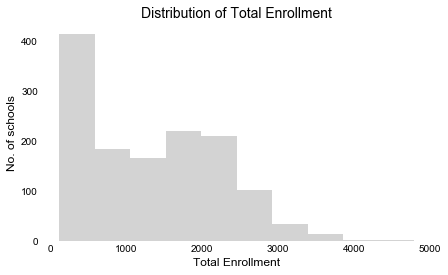

In [486]:
# make a histogram of school enrollment
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
ax1.hist(dfInfoAllBySchoolw25['ETOT'], color='#d3d3d3')

# control labels
ax1.set_title('Distribution of Total Enrollment', size=14)
ax1.set_xlabel('Total Enrollment', size=12)
ax1.set_ylabel('No. of schools', size=12)
plt.yticks((np.arange(0, 500, 100)))  # change y-axis to hundreds

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save figure
#plt.savefig('hist_TotalEnrollment.png', dpi=400)

In [487]:
# enrollment by school type (decided to show by chart)
dfTemp = dfInfoAllBySchoolw25.groupby('SOCType')[['ETOT', 'DTOT']].agg('sum')
dfTemp2 = dfTemp.sort_values(by='ETOT', ascending=False)
#dfTemp2.to_csv('totalEnrollment_bySOCType.csv')

In [488]:
# enrollment by ethnicity, need to make a new dataframe before plotting

# filter by only indexes with the 25 students-per-grade criteria
k = dfInfoAllBySchoolw25['CDSCode']
dfInfoAllw25 = dfInfoAll[dfInfoAll['CDS_CODE'].isin(k)]
# enrollment by ethnicity
dfInfo_ByEthnicity = dfInfoAllw25.loc[:,'CDS_CODE':'DTOT'].groupby('ETHNIC').agg(sum).drop('CDS_CODE', axis=1)

# create a dictionary for ethnicity decoding
diEth = {0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian", 3: "Pacific Islander", 4:"Filipino", 5: "Hispanic", 6: "African American", 7: "White", 9: "Two or More Races"}
dfInfo_ByEthnicity['ethnicity'] = dfInfo_ByEthnicity.index
dfInfo_ByEthnicity.replace({'ethnicity': diEth}, inplace=True)

In [489]:
dfTemp = dfInfo_ByEthnicity[['ETOT', 'ethnicity']].sort_values(by='ETOT', ascending=False)

In [490]:
dfTemp

,ETOT,ethnicity
ETHNIC,,
5,942267,Hispanic
7,455583,White
2,169099,Asian
6,108463,African American
4,55461,Filipino
9,45719,Two or More Races
1,10196,Native Amer/Alaska Native
3,9458,Pacific Islander
0,8202,Not reported


/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


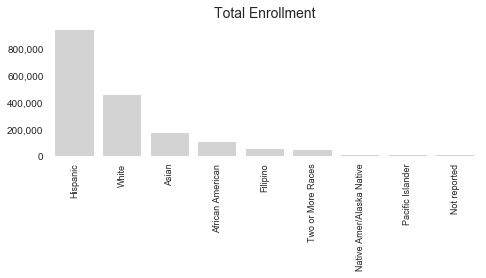

In [493]:
# enrollment by ethnicity, barplot
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
sns.barplot(x='ethnicity', y='ETOT', data=dfTemp, color='#d3d3d3', ax=ax1)
xorder = dfTemp['ethnicity']
# plot formatting
ax1.set_xticklabels(labels=xorder, rotation=90, size=9)
ax1.set(xlabel='', ylabel='')
ax1.set_title('Total Enrollment', size=14)
# put commas in y-axis
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.45, top=0.91, left=0.12, right=0.97)

# save figure
#plt.savefig('TotalEnrollment_byEthnicity.png', dpi=400)

In [494]:
dfInfo_ByEthnicity 

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,D9,D10,D11,D12,DUS,DTOT,ethnicity
ETHNIC,,,,,,,,,,,,,,,,,
0,289,291,3015,2224,1600,1359,4,8202,8,10,160,39,68,97,0,364,Not reported
1,143,157,2662,2628,2440,2448,18,10196,1,4,24,34,46,111,2,217,Native Amer/Alaska Native
2,1315,1316,42190,44581,41045,40998,285,169099,10,6,70,85,107,596,3,861,Asian
3,98,94,2311,2427,2316,2386,18,9458,3,1,19,27,29,84,0,159,Pacific Islander
4,567,549,13599,13865,13766,14132,99,55461,2,1,30,24,33,190,4,281,Filipino
5,10982,11165,253121,247506,224707,215485,1448,942267,94,99,3074,2786,3211,8719,86,17876,Hispanic
6,1516,1759,28015,27615,26377,26226,230,108463,31,31,425,452,553,1394,17,2841,African American
7,6276,6607,114424,115622,112655,111993,889,455583,72,65,485,577,826,2260,17,4165,White
9,848,883,12082,11756,11206,10612,63,45719,10,11,78,94,111,300,2,585,Two or More Races


In [495]:
print('gender breakdown: ', dfInfoAllw25.groupby('GENDER')['ETOT'].agg('sum'))

gender breakdown:  GENDER
F    886534
M    917914
Name: ETOT, dtype: int64


In [496]:
# clean up the median income column

# convert '(X)' to nan
k = (dfInfoAllBySchoolw25['medianIncome']=='(X)') | (dfInfoAllBySchoolw25['medianIncome']=='-') 
dfInfoAllBySchoolw25.loc[k,'medianIncome'] = pd.to_numeric(dfInfoAllBySchoolw25.loc[k,'medianIncome'], errors='coerce')

# all other NaNs will stay there but dropped during histogram plotting
dfInfoAllBySchoolw25['medianIncome'] = dfInfoAllBySchoolw25['medianIncome'].fillna(np.nan).astype(np.float64)

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [497]:
# number of schools/zip codes that didn't have a value for median income
print("No. of schools/zip codes missing value for median income: ", dfInfoAllBySchoolw25['medianIncome'].isnull().sum())

No. of schools/zip codes missing value for median income:  18


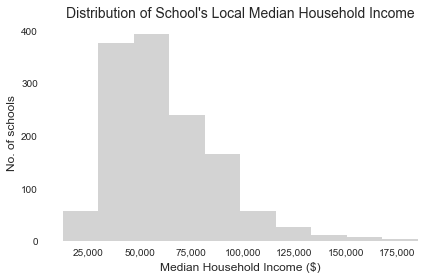

In [498]:
# make a histogram of school median household income
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
ax1.hist(dfInfoAllBySchoolw25['medianIncome'].dropna(), color='#d3d3d3')

# control labels
ax1.set_title("Distribution of School's Local Median Household Income", size=14)
ax1.set_xlabel('Median Household Income ($)', size=12)
ax1.set_ylabel('No. of schools', size=12)
plt.yticks((np.arange(0, 500, 100)))  # change y-axis to hundreds
# put commas in x-axis
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save figure
#plt.savefig('hist_medHouseholdIncome.png', dpi=400)

In [499]:
# clean up the percFamilyBelowPovertyLevel column

# convert '(X)' to nan
k = (dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel']=='(X)') | (dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel']=='-') 
dfInfoAllBySchoolw25.loc[k,'percFamilyBelowPovertyLevel'] = pd.to_numeric(dfInfoAllBySchoolw25.loc[k,'percFamilyBelowPovertyLevel'], errors='coerce')

# all other NaNs will stay there but dropped during histogram plotting
dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel'] = dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel'].fillna(np.nan).astype(np.float64)

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [500]:
# number of schools/zip codes that didn't have a value for percFamilyBelowPovertyLevel
print("No. of schools/zip codes missing value for % Family Below Poverty Level: ", dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel'].isnull().sum())

No. of schools/zip codes missing value for % Family Below Poverty Level:  17


In [501]:
dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel'].head()

2     14.5
42     4.0
46     8.2
53     8.2
55     8.2
Name: percFamilyBelowPovertyLevel, dtype: float64

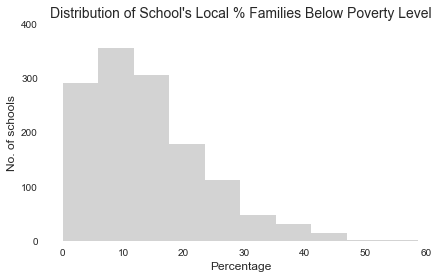

In [502]:
# make a histogram of school median household income
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
ax1.hist(dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel'].dropna(), color='#d3d3d3')

# control labels
ax1.set_title("Distribution of School's Local % Families Below Poverty Level", size=14)
ax1.set_xlabel('Percentage', size=12)
ax1.set_ylabel('No. of schools', size=12)
plt.yticks((np.arange(0, 500, 100)))  # change y-axis to hundreds
# put commas in x-axis
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save figure
#plt.savefig('hist_percFamilyBelowPovertyLevel.png', dpi=400)

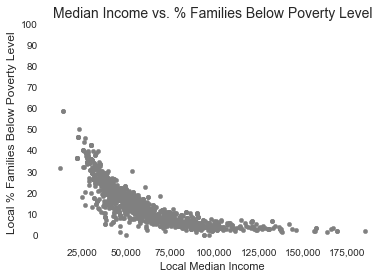

In [503]:
# Assess correlation between median income and percFamilyBelowPovertyLevel

f, (ax1) = plt.subplots(1, 1, figsize=(6,4))
x = dfInfoAllBySchoolw25['medianIncome']
y = dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel']
ax1.scatter(x, y, s=20, color='#808080')  # hex code for gray

# set axis properties
plt.yticks((np.arange(0, 105, 10)))  # change y-axis to hundreds
# ax1.set_ylim([0,2.2]) # change y axis scale
ax1.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# plot formatting
ax1.set(xlabel='Local Median Income')
ax1.set_ylabel('Local % Families Below Poverty Level', size=12)
ax1.set_title('Median Income vs. % Families Below Poverty Level', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save figure
#plt.savefig('MediaIncome_vs_PercFamiliesBelowPovertyLevel.png', dpi=400)

In [504]:
# Dropout percentage by ethnicity
dfInfo_ByEthnicity['% dropout'] = 100*dfInfo_ByEthnicity['DTOT']/dfInfo_ByEthnicity['ETOT'] 

In [505]:
dfTemp = dfInfo_ByEthnicity[['ETOT','% dropout', 'ethnicity']].sort_values(by='% dropout', ascending=False)
dfTemp

,ETOT,% dropout,ethnicity
ETHNIC,,,
0,8202,4.437942,Not reported
6,108463,2.619326,African American
1,10196,2.128286,Native Amer/Alaska Native
5,942267,1.897127,Hispanic
3,9458,1.681117,Pacific Islander
9,45719,1.279556,Two or More Races
7,455583,0.914213,White
2,169099,0.509169,Asian
4,55461,0.506662,Filipino


In [52]:
#dfTemp.to_csv('percDropoutByEthnicity.csv')

In [506]:
# % dropouts across all students in CA
totalDropoutPerc = 100*(dfInfo_ByEthnicity['DTOT'].sum()/dfInfo_ByEthnicity['ETOT'].sum())

print('Dropout percentage for all of CA: ', totalDropoutPerc)

Dropout percentage for all of CA:  1.51564356523


/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


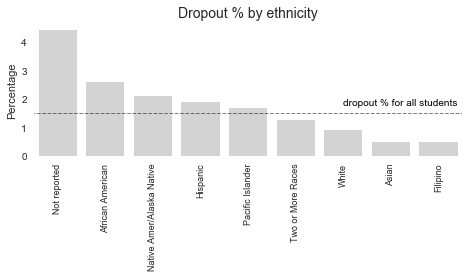

In [507]:
# dropout percentage by ethnicity, barplot
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
sns.barplot(x='ethnicity', y='% dropout', data=dfTemp, color='#d3d3d3', ax=ax1)
xorder = dfTemp['ethnicity']
# plot formatting
ax1.set_xticklabels(labels=xorder, rotation=90, size=9)
ax1.set(xlabel='', ylabel='Percentage')
ax1.set_title('Dropout % by ethnicity', size=14)

# add a cutoff line and text showing the percentage across all students
ax1.plot([-1, len(xorder)], [totalDropoutPerc, totalDropoutPerc], linewidth=1, linestyle='dashed', color='black', alpha=0.5)  # works with ax1

ax1.text(len(xorder)-3, totalDropoutPerc+0.25, 'dropout % for all students',
         fontsize=10, color='black')

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.45, top=0.91, left=0.12, right=0.97)

# save figure
#plt.savefig('DropoutPerc_byEthnicity.png', dpi=400)

In [508]:
# % dropouts by gender
dfTemp = dfInfoAllw25.groupby('GENDER')[['ETOT', 'DTOT']].agg('sum')
dfTemp['% dropouts'] = 100*dfTemp['DTOT']/dfTemp['ETOT'] 

In [56]:
#dfTemp.to_csv('DropoutPerc_byGender.csv')

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


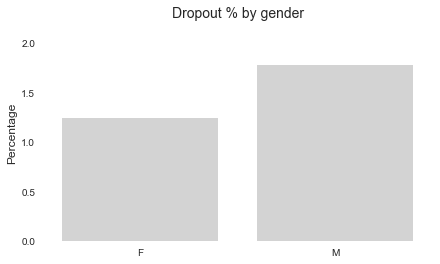

In [509]:
# dropout percentage by gender, barplot
f, (ax1) = plt.subplots(1, 1, figsize=(7,4))
sns.barplot(x=dfTemp.index, y=dfTemp['% dropouts'], color='#d3d3d3', ax=ax1)

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('Percentage', size=12)
ax1.set_title('Dropout % by gender', size=14)
plt.yticks((np.arange(0, 2.2, 0.5)))  # change y-axis to hundreds
ax1.set_ylim([0,2.2]) # change y axis scale

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save figure
#plt.savefig('DropoutPerc_byGender.png', dpi=400)

In [510]:
# make bins of median income in intervals of $15,000
dfInfoAllBySchoolw25.loc[:,'medianIncomeBins'] = dfInfoAllBySchoolw25['medianIncome'] // 15000 * 15000

/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [511]:
sorted(dfInfoAllBySchoolw25.loc[:,'medianIncomeBins'].unique().tolist())

[0.0,
 15000.0,
 30000.0,
 45000.0,
 60000.0,
 75000.0,
 90000.0,
 105000.0,
 120000.0,
 135000.0,
 nan,
 150000.0,
 165000.0,
 180000.0]

In [512]:
# remove na values
dfTemp = dfInfoAllBySchoolw25[['medianIncomeBins', 'dropout %']].dropna()
# make integer for labeling purposes
dfTemp['medianIncomeBins'] = dfTemp['medianIncomeBins'].astype(np.int64)

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


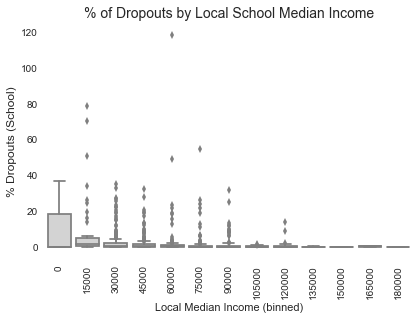

In [513]:
# Show boxplots by median income and % dropout rate

f, (ax1) = plt.subplots(1, 1, figsize=(6,5));

# -- ax1 --
xorder = sorted(dfTemp.loc[:,'medianIncomeBins'].unique().tolist());
xorder2 = ["{:,}".format(x) for x in xorder];
sns.boxplot(x='medianIncomeBins', y='dropout %', data=dfTemp, order=xorder, color='#d3d3d3', ax=ax1);   # hex value for light gray, order=xorder, 

# # plot formatting
ax1.set(xlabel='Local Median Income (binned)')
ax1.set_ylabel('% Dropouts (School)', size=12)
ax1.set_title('% of Dropouts by Local School Median Income', size=14)
ax1.set_xticklabels(labels=xorder, rotation=90);

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.25, top=0.9, left=0.12, right=0.97)

# save figure
#plt.savefig('PercDropouts_byLocalMedianIncome.png', dpi=400)

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


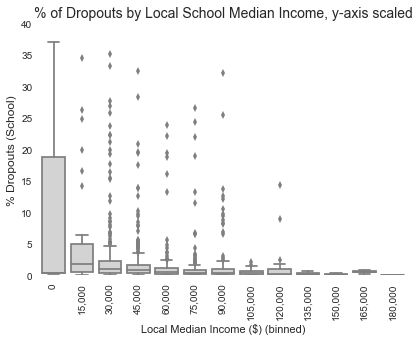

In [514]:
# Show boxplots by median income and % dropout rate, scale y-axis

f, (ax2) = plt.subplots(1, 1, figsize=(6,5));

# --- ax2 --
xorder = sorted(dfTemp.loc[:,'medianIncomeBins'].unique().tolist());
xorder2 = ["{:,}".format(x) for x in xorder];
sns.boxplot(x='medianIncomeBins', y='dropout %', data=dfTemp, order=xorder, color='#d3d3d3', ax=ax2);   # hex value for light gray, order=xorder, 

# set axis properties
ax2.set_ylim([0,40]); # change y axis scale
ax2.set_xticklabels(labels=xorder2, rotation=90);

# plot formatting
ax2.set(xlabel='Local Median Income ($) (binned)')
ax2.set_ylabel('% Dropouts (School)', size=12)
ax2.set_title('% of Dropouts by Local School Median Income, y-axis scaled', size=14)

# add text of y-axis scaled - for whatever reason, this is causing the kernel to crash
# ax2.text(165000, 35, 'y-axis scaled', fontsize=8, ha='right')

# figure properties
sns.set(font='Franklin Gothic Book')
ax2.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.2, top=0.9, left=0.12, right=0.97)

# save figure
#plt.savefig('PercDropouts_byLocalMedianIncome_yaxisScaled.png', dpi=400)

In [515]:
dfInfoAllBySchoolw25['percFamilyBelowPovertyLevel']

2        14.5
42        4.0
46        8.2
53        8.2
55        8.2
56       30.9
58        8.2
84        8.9
103      13.4
106      14.1
144       6.2
166      13.0
174       5.4
177       4.0
179       4.0
180       4.0
181       2.2
182       5.4
233       6.9
235       6.9
244      14.3
246       6.9
248      10.8
301       4.4
306       2.5
307       2.5
346       5.8
376       5.8
393      15.1
396      21.1
         ... 
17401     2.4
17402    16.9
17403    16.9
17405    12.1
17406    15.4
17451     5.4
17453     3.4
17455     5.4
17497     9.5
17498     6.3
17499     6.3
17502    12.0
17538     3.3
17540     4.7
17541     5.5
17573     5.8
17586     4.1
17599    16.0
17631     7.6
17650     8.7
17665    11.7
17686     6.6
17693     9.3
17698    10.9
17726    21.2
17738    21.2
17747    15.4
17753    21.2
17754    21.2
17799     9.3
Name: percFamilyBelowPovertyLevel, Length: 1352, dtype: float64

In [516]:
# Show boxplots by percentage by school type
dfTemp = dfInfoAllBySchoolw25[['SOCType', 'dropout %']].dropna()

In [517]:
dfTemp2 = dfTemp.groupby('SOCType')['dropout %'].agg([np.median, 'count'])
dfTemp2

,median,count
SOCType,,
Alternative Schools of Choice,0.500664,42
Continuation High Schools,16.852295,4
County Community,20.900322,11
District Community Day Schools,17.567568,1
Elementary Schools (Public),1.000000,1
High Schools (Public),0.569260,1133
High Schools In 1 School Dist. (Public),0.176056,2
Juvenile Court Schools,49.494949,3
K-12 Schools (Public),1.587702,136


In [518]:
xorder = dfTemp2.sort_values(by='median', ascending=False).index

In [519]:
dfTemp2.sort_values(by='median', ascending=False).to_csv('dropoutPerc_bySchoolType_df.csv')

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


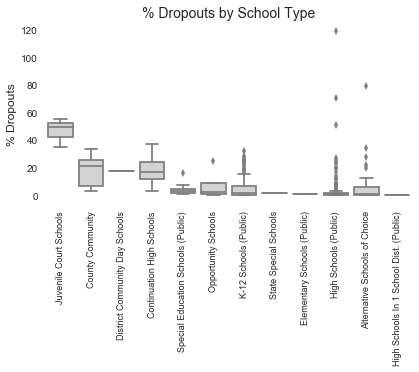

In [520]:
f, (ax1) = plt.subplots(1, 1, figsize=(6,5));

sns.boxplot(x='SOCType', y='dropout %', data=dfTemp, order=xorder, color='#d3d3d3', ax=ax1);   # hex value for light gray, order=xorder, 

# set axis properties
ax1.set_xticklabels(labels=xorder, rotation=90, size=9);

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('% Dropouts', size=12)
ax1.set_title('% Dropouts by School Type', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# # to accomodate labeling
plt.subplots_adjust(bottom=0.45, top=0.95, left=0.12, right=0.97)

# save figure
# plt.savefig('PercDropouts_bySchoolType.png', dpi=400)

### Analysis 2: Identification of peer schools with similar makeup


#### Show clustering of schools based on demographic profile
- Create a dataframe that shows each school's enrollment by ethnicity and median income
- Standardize the dataframe
- Run PCA on the standardized demographic dataframe

In [521]:
# create a dataframe that shows each school's total enrollment by ethnicity enrollment
dfTemp = dfInfoAll.loc[:,:'ETOT']
dfTemp2 = dfTemp.groupby(['CDS_CODE', 'ETHNIC']).agg(sum)
dfTemp2.reset_index(inplace=True) 
dfTemp3 = pd.pivot_table(dfTemp2, index='CDS_CODE', columns='ETHNIC', values='ETOT').fillna(0)

In [522]:
dfTemp3.head()

ETHNIC,0,1,2,3,4,5,6,7,9
CDS_CODE,,,,,,,,,
1100170112607,8.0,5.0,7.0,3.0,1.0,209.0,156.0,13.0,5.0
1100170123968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1100170130401,0.0,0.0,5.0,0.0,0.0,45.0,57.0,6.0,8.0
1100170130419,0.0,1.0,14.0,5.0,5.0,115.0,83.0,16.0,7.0
1100170131581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [523]:
# by merge, only schools with 25 students and enrollment profile
dfInfo_schoolByEthEc = pd.merge(dfInfoAllBySchoolw25[['CDSCode', 'percFamilyBelowPovertyLevel', 'dropout %', 'medianIncome', ]], dfTemp3, how='left', left_on='CDSCode', right_index=True)
dfInfo_schoolByEthEc.set_index('CDSCode', inplace=True)
dfInfo_schoolByEthEc.head()

In [526]:
# ethnic profile by proportions
dfTemp4 = dfInfo_schoolByEthEc.loc[:,[0,1,2,3,4,5,6,7,9]].div(dfInfo_schoolByEthEc.loc[:,[0,1,2,3,4,5,6,7,9]].sum(axis=1), axis=0)

In [527]:
# min-max normalize the median income
from sklearn import preprocessing

X = dfInfo_schoolByEthEc['medianIncome']
dfInfo_schoolByEthEc['medianIncomeStd'] = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [528]:
# exploring standardizing (mean is 0 and other values are number of SDs away)
X = dfInfo_schoolByEthEc['medianIncome'].dropna()
preprocessing.scale(X)


array([-1.14674852,  1.10932768,  0.43545178, ..., -0.67638394,
       -0.67638394,  0.07812701])

In [529]:
dfTemp4['medianIncomeStd'] = dfInfo_schoolByEthEc['medianIncomeStd']

In [530]:
dfTemp4.head(100)

,0,1,2,3,4,5,6,7,9,medianIncomeStd
CDSCode,,,,,,,,,,
1100170112607,0.019656,0.012285,0.017199,0.007371,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286
1316170131763,0.000000,0.004808,0.057692,0.004808,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878
1611190106401,0.000000,0.000000,0.582857,0.022857,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132
1611190130229,0.000582,0.001746,0.403376,0.007567,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132
1611190130609,0.009804,0.004902,0.181373,0.000000,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132
1611190130625,0.006061,0.000000,0.000000,0.000000,0.006061,0.927273,0.054545,0.006061,0.000000,0.110951
1611190132142,0.001923,0.002885,0.206731,0.010577,0.153846,0.163462,0.171154,0.221154,0.068269,0.349132
1611270130450,0.000826,0.002479,0.285950,0.003306,0.017355,0.166116,0.048760,0.371901,0.103306,0.396128
1611430122697,0.013661,0.000000,0.010929,0.002732,0.005464,0.644809,0.218579,0.043716,0.060109,0.256786


#### Make a table to show how median values are standardized

In [531]:
dfInfo_schoolByEthEc.loc[:,['medianIncome', 'medianIncomeStd']].shape

(1352, 2)

In [532]:
# Make a sorted table. Drop na is necessary due to schools that have missing values
dfTemp = dfInfo_schoolByEthEc.loc[:,['medianIncome', 'medianIncomeStd']].sort_values(by='medianIncome').dropna()
dfTemp.head()

,medianIncome,medianIncomeStd
CDSCode,,
19647331930387,12813.0,0.000000
39686760119743,14579.0,0.010264
39686760120733,14579.0,0.010264
19647330106864,22304.0,0.055162
14101400128454,22304.0,0.055162


In [533]:
dfTemp.tail()

,medianIncome,medianIncomeStd
CDSCode,,
19647331995836,166021.0,0.890444
43695344334371,166761.0,0.894745
43694014336137,169206.0,0.908955
43695344337762,169206.0,0.908955
43696094334116,184871.0,1.000000


In [534]:
dfTemp.shape

(1334, 2)

In [535]:
# Take evenly spaced rows. Need to take one less than the length of the dataframe.
k, kNumSchools = np.linspace(0, len(dfTemp)-1, num=11, retstep=True)
# round it and make an integer
ki = [int(round(x)) for x in k]
print('Rows to take in dataframe: ', ki)
print('Number of schools in an interval: ', kNumSchools)

Rows to take in dataframe:  [0, 133, 267, 400, 533, 666, 800, 933, 1066, 1200, 1333]
Number of schools in an interval:  133.3


In [536]:
dfTemp.iloc[ki,:]

,medianIncome,medianIncomeStd
CDSCode,,
19647331930387,12813.0,0.000000
19647331935121,34994.0,0.128916
24657890127373,40323.0,0.159888
19648081930155,45898.0,0.192290
19647331931864,51206.0,0.223140
39685933932001,56651.0,0.254786
39685930116376,62731.0,0.290123
42691464230587,72064.0,0.344366
48705734837803,81800.0,0.400952


In [89]:
dfTemp.tail(50)

,medianIncome,medianIncomeStd
CDSCode,,
1.964683e+13,114688.0,0.592097
3.166928e+13,115217.0,0.595171
1.750930e+12,116199.0,0.600879
3.066597e+13,116996.0,0.605511
4.369641e+13,117976.0,0.611207
9.618531e+12,119152.0,0.618042
3.768338e+13,120496.0,0.625853
5.673875e+13,120696.0,0.627015
3.868478e+13,121167.0,0.629753


#### Make a sorted plot

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


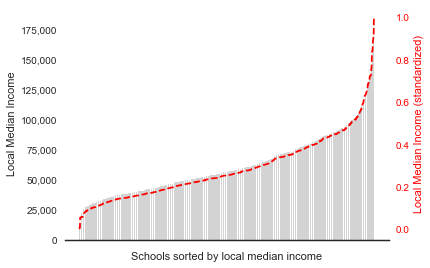

In [538]:
# Sorted barplot for median incomes
f, (ax1) = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=list(range(len(dfTemp))), y='medianIncome', data=dfTemp, color='#d3d3d3', ax=ax1)

# plot formatting
ax1.set_xticklabels('');
ax1.set(xlabel='Schools sorted by local median income', ylabel='Local Median Income')

# put commas in y-axis
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# add the standardized value on a second y-axis, make red
ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(), dfTemp['medianIncomeStd'], linestyle='dashed', c='red')
ax2.set_ylabel('Local Median Income (standardized)', color='red')
ax2ylabels = ax2.get_yticks()
ax2.set_yticklabels(labels=ax2ylabels, color='red')

# Hide the right and top spines
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')

# line below is intended to remove frame, but this moves the xaxis labels which is why it's commented out
# sns.despine(left=True, bottom=True, right=True)   

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.91, left=0.15, right=0.90)

# save figure
#plt.savefig('SchoolsRanked_MedianIncome.png', dpi=400)

#### Visualization of income inequality:
A median income of $100,000 is only a standardized value of 0.5. Only about 10% of schools are in an area that comprise the top 50% of the median income range.

In [539]:
dfTemp.iloc[ki,0].mean() + dfTemp.iloc[ki,0].std()

112110.65153617751

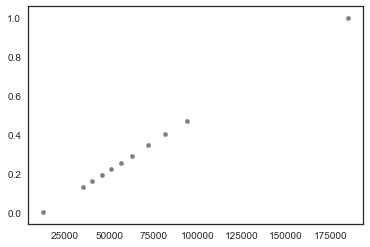

In [540]:
# assess for relationship between median income and standardized median income
f, (ax1) = plt.subplots(1, 1, figsize=(6,4))
x = dfTemp.iloc[ki,0]
y = dfTemp.iloc[ki,1]
ax1.scatter(x, y, s=20, color='#808080')

In [93]:
#diEth = {0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian", 3: "Pacific Islander", 4:"Filipino", 5: "Hispanic", 6: "African American", 7: "White", 9: "Two or More Races"}

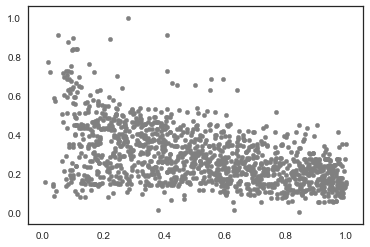

In [541]:
f, (ax1) = plt.subplots(1, 1, figsize=(6,4))
x = dfTemp4[5]
y = dfTemp4['medianIncomeStd']
ax1.scatter(x, y, s=20, color='#808080')

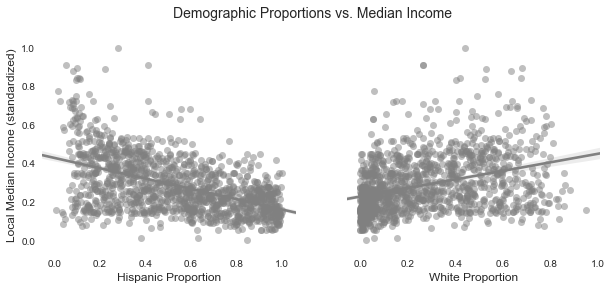

In [542]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# ax1 plot and formatting
sns.regplot(x=dfTemp4[5], y='medianIncomeStd', data=dfTemp4, color='gray', 
                  scatter_kws={'alpha':'0.5'}, ax=ax1)                       
ax1.set_xlabel('Hispanic Proportion', size=12)
ax1.set_ylabel('Local Median Income (standardized)', size=12)
#ax1.set_title('Hispanic Proportion vs. Local Median Income', size=14)
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks

# ax2 plot and formatting
sns.regplot(x=dfTemp4[7], y='medianIncomeStd', data=dfTemp4, color='gray', 
                  scatter_kws={'alpha':'0.5'}, ax=ax2)                       
ax2.set_xlabel('White Proportion', size=12)
ax2.set_ylabel('')
#ax2.set_title('White Proportion vs. Local Median Income', size=14)
ax2.tick_params(axis='both', which='both',length=0)   # remove tick marks

# figure properties
sns.set(font='Franklin Gothic Book')
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

f.suptitle('Demographic Proportions vs. Median Income', size=14)

# # to accomodate labeling
# plt.subplots_adjust(bottom=0.45, top=0.95, left=0.12, right=0.97)

# save figure
# plt.savefig('DemographicProportion_vs_MedianIncome.png', dpi=400)

In [543]:
# determine min and max
print("Smallest median income: ", dfInfo_schoolByEthEc['medianIncome'].min(axis=0))
print("Largest median income: ", dfInfo_schoolByEthEc['medianIncome'].max(axis=0))

Smallest median income:  12813.0
Largest median income:  184871.0


#### Run PCA

In [544]:
# apply standard variables for scikit learn
dfTemp5 = dfTemp4.dropna() # the dataframe for ML, na's removed for PCA

In [545]:
# count the number of na in a dataframe
dfTemp5.isnull().sum()

0                  0
1                  0
2                  0
3                  0
4                  0
5                  0
6                  0
7                  0
9                  0
medianIncomeStd    0
dtype: int64

In [546]:
# plot schools by PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dfTemp5)
X = pca.transform(dfTemp5)
X1 = pca.fit(X).transform(X)

In [547]:
dfTemp5['PCAx'] = X1[:,0]
dfTemp5['PCAy'] = X1[:,1]

/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [548]:
dfTemp5.head()

,0,1,2,3,4,5,6,7,9,medianIncomeStd,PCAx,PCAy
CDSCode,,,,,,,,,,,,
1100170112607,0.019656,0.012285,0.017199,0.007371,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311
1316170131763,0.000000,0.004808,0.057692,0.004808,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117
1611190106401,0.000000,0.000000,0.582857,0.022857,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797
1611190130229,0.000582,0.001746,0.403376,0.007567,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371
1611190130609,0.009804,0.004902,0.181373,0.000000,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610


#### Make different PCA representations and color/size by different attributes
- dropout percentage (color or size)
- school type (color)
- total enrollment (color or size)
- percentage of ethnicity (separate plots)

In [549]:
# dataframe for plotting
df_forPCA = pd.merge(dfInfo_schoolByEthEc, dfTemp5, how='right', left_index=True, right_index=True)

In [550]:
df_forPCA.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,2_y,3_y,4_y,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.017199,0.007371,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.057692,0.004808,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.582857,0.022857,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.403376,0.007567,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.181373,0.000000,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610


In [551]:
# add total enrollment to dataframe
df_forPCA['totalEnroll'] = df_forPCA.loc[:,['0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','9_x']].sum(axis=1)

In [552]:
df_forPCA.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,3_y,4_y,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.007371,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.004808,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.022857,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.007567,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.000000,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0


In [553]:
# merge to add school type
df_forPCA2 = pd.merge(df_forPCA, dfPS[['CDSCode', 'SOCType']], how='left', left_index=True, right_on='CDSCode')

In [554]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,CDSCode,SOCType
2,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,1100170112607,High Schools (Public)
42,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,1316170131763,State Special Schools
46,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,1611190106401,Alternative Schools of Choice
53,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,1611190130229,High Schools (Public)
55,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,1611190130609,K-12 Schools (Public)


#### make dropout percentage categories

In [555]:
df_forPCA2.set_index('CDSCode', inplace=True)

In [556]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,4_y,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public)
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,State Special Schools
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,Alternative Schools of Choice
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,High Schools (Public)
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,K-12 Schools (Public)


In [557]:
# Evaluation of my high school
dfPS[dfPS['School'].str.contains('Bonita Vista', na=False)]

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpdate,ZipSimple
12804,37684113730405,638640.0,6475.0,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,NaN,NaN,NaN,NaN,NaN,NaN,8/16/2017,91913
12823,37684116059745,638640.0,6474.0,Active,San Diego,Sweetwater Union High,Bonita Vista Middle,650 Otay Lakes Road,650 Otay Lakes Rd.,Chula Vista,...,Reyes,eduardo.reyes@sweetwaterschools.org,NaN,NaN,NaN,NaN,NaN,NaN,8/6/2015,91910


In [558]:
df_forPCA2['medianIncome'].mean()

61905.23388305847

In [559]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,4_y,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.002457,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public)
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.052885,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,State Special Schools
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.120000,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,Alternative Schools of Choice
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.052969,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,High Schools (Public)
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.053922,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,K-12 Schools (Public)


In [560]:
# set dropout category according to thresholds: 0: 0-1%, 1:1-2%, 2: 2-5%, 3: >5%
# 5-10%, 4: >10    # previously considered 5 categories but will limit to 4

# by exclusion, the category 0 will be those that have <1% dropout
df_forPCA2['dropout category'] = 0
#dfTemp_wSchoolInfo['% dropouts]

# boolean for 1-2%
k1 = df_forPCA2[(df_forPCA2['dropout %'] > 1) & (df_forPCA2['dropout %'] <= 2)].index
df_forPCA2.loc[k1,'dropout category']=1

# boolean for 2-5%
k2 = df_forPCA2[(df_forPCA2['dropout %'] > 2) & (df_forPCA2['dropout %'] <= 5)].index
df_forPCA2.loc[k2,'dropout category']=2

# boolean for >5%
k3 = df_forPCA2[(df_forPCA2['dropout %'] > 5)].index
df_forPCA2.loc[k3,'dropout category']=3

# boolean for >10%
# k4 = df_forPCA2[(df_forPCA2['dropout %'] > 10)].index
# df_forPCA2.loc[k4,'dropout category']=4

In [561]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType,dropout category
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public),0
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,State Special Schools,1
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,Alternative Schools of Choice,0
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,High Schools (Public),0
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,K-12 Schools (Public),0


In [562]:
# Make a table for the dropout percentage thresholds

dfPercThresholdGroups = df_forPCA2.groupby('dropout category').count().loc[:,:'dropout %']
dfPercThresholdGroups 

,percFamilyBelowPovertyLevel,dropout %
dropout category,,
0,836,836
1,246,246
2,150,150
3,102,102


In [563]:
dfPercThresholdGroups.rename(columns={'percFamilyBelowPovertyLevel': 'No. of schools', 'dropout %': 'dropout % values'}, inplace=True)

In [564]:
# Manually rename dropout % values according to threshold
dfPercThresholdGroups.loc[0, 'dropout % values'] = '0-1%'
dfPercThresholdGroups.loc[1, 'dropout % values'] = '1-2%'
dfPercThresholdGroups.loc[2, 'dropout % values'] = '2-5%'
dfPercThresholdGroups.loc[3, 'dropout % values'] = '>5%'
#dfPercThresholdGroups.loc[4, 'dropout % values'] = '>10%'

#1:1-2%, 2: 2-5%, 3: 5-10%, 4: >10
dfPercThresholdGroups[['dropout % values', 'No. of schools']].to_csv('DropoutPercentThresholdGroups.csv')

In [565]:
dfPercThresholdGroups

,No. of schools,dropout % values
dropout category,,
0,836,0-1%
1,246,1-2%
2,150,2-5%
3,102,>5%


In [566]:
# Make a histogram with uneven widths (followed stack overflow)
#...and a broken y-axis via https://matplotlib.org/examples/pylab_examples/broken_axis.html

dfPercThresholdGroups['No. of schools']

dropout category
0    836
1    246
2    150
3    102
Name: No. of schools, dtype: int64

In [567]:
freqs = dfPercThresholdGroups['No. of schools']
bins = np.array([0, 1, 2, 5, 10])
widths = bins[1:] - bins[:-1]
heights = freqs.astype(np.float)/widths


In [568]:
heights

dropout category
0    836.0
1    246.0
2     50.0
3     20.4
Name: No. of schools, dtype: float64

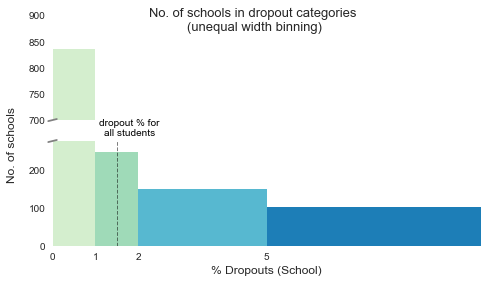

In [569]:
# Uneven width histogram, with colors, with broken axis

freqs = dfPercThresholdGroups['No. of schools']
bins = np.array([0, 1, 2, 5, 10])
widths = bins[1:] - bins[:-1]
heights = freqs  #.astype(np.float)/widths   # commented out a consideration for other cases

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,4), sharex=True)

# color code the histogram plots to correspond to the PCA plot
my_cmap = sns.color_palette("GnBu", 4)

# make top axis plots, each dropout category represented
ax1.fill_between(bins[[0,1]], heights[[0,0]], facecolor=my_cmap[0])  # category 0
ax1.fill_between(bins[[1,2]], heights[[1,1]], facecolor=my_cmap[1])  # category 1
ax1.fill_between(bins[[2,3]], heights[[2,2]], facecolor=my_cmap[2])  # category 2
ax1.fill_between(bins[[3,4]], heights[[3,3]], facecolor=my_cmap[3])  # category 3

# make bottom axis plots, each dropout category represented
ax2.fill_between(bins[[0,1]], heights[[0,0]], facecolor=my_cmap[0])  # category 0
ax2.fill_between(bins[[1,2]], heights[[1,1]], facecolor=my_cmap[1])  # category 1
ax2.fill_between(bins[[2,3]], heights[[2,2]], facecolor=my_cmap[2])  # category 2
ax2.fill_between(bins[[3,4]], heights[[3,3]], facecolor=my_cmap[3])  # category 3

# change x tick marks and x-limit so it only shows desired intervals
plt.xticks([0,1,2,5])
ax2.set_xlim(0, 10)

# adjust the y-axis range for each/limit the view to different portions of the data
ax1.set_ylim(700, 900)  # for category 0
#plt.yticks(np.arange(800, 875, 50))

ax2.set_ylim(0, 275)  # most of the data
#plt.yticks((np.arange(0, 860, 200)))

# hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# make slash marks
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='gray', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# plot labeling
f.suptitle('No. of schools in dropout categories \n(unequal width binning)', size=13)
f.text(0.02, 0.5, 'No. of schools', ha='center', va='center', rotation='vertical')
ax2.set_xlabel('% Dropouts (School)', size=12)


# add a cutoff line and text showing the percentage across all students
#ax1.plot([1.5, 1.5], [0, 775], linewidth=1, linestyle='dashed', color='black', alpha=0.5)  
ax2.plot([1.5, 1.5], [0, 875], linewidth=1, linestyle='dashed', color='black', alpha=0.5)  
ax1.text(1.8, 670, 'dropout % for\nall students', fontsize=10, color='black', ha='center')

# figure properties
sns.set(font='Franklin Gothic Book')
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to adjust spaces between
plt.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.95)

# save figure
#plt.savefig('DropoutCategory_binning.png', dpi=400)

#### PCA visualizations

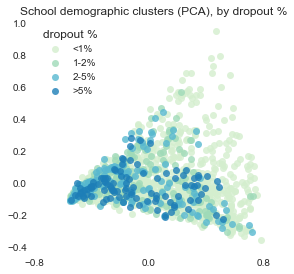

In [572]:
# PCA, colored by dropout category

#f, ax1 = plt.subplots(1, 1, figsize=(6,4));
ax1 = sns.lmplot(x='PCAx', y='PCAy', data=df_forPCA2,
                 hue='dropout category', ci=None,
                 legend=False,
                 fit_reg=False,
                 size=4, palette=sns.color_palette("GnBu", 4))

ax1.set(xlabel='', ylabel='')
ax1.set(title='School demographic clusters (PCA), by dropout %')

new_labels = ['<1%', '1-2%', '2-5%', '>5%']

plt.legend(loc=0, labels=new_labels, title='dropout %')
# replace figure labels
# for t, l in zip(plt._legend.texts, new_labels): t.set_text(l)

# figure properties
sns.set(font='Franklin Gothic Book')
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame
plt.xticks((np.arange(-.8, 0.9, 0.8)))

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.12, right=0.95)

# save figure
#plt.savefig('PCA_byDropoutPerc.png', dpi=400)

In [573]:
# Is dark colored corner of PCA just due to density of plots?

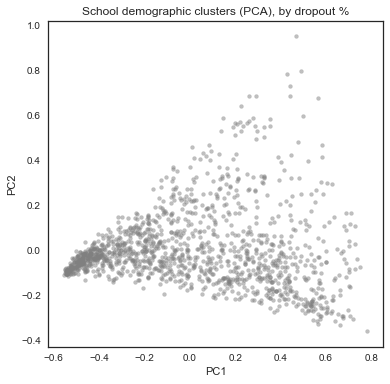

In [574]:
# PCA, colored by dropout category with matplotlib

f, (ax1) = plt.subplots(1, 1, figsize=(6,6))
points = ax1.scatter(x=df_forPCA2['PCAx'], y=df_forPCA2['PCAy'], c='gray', alpha=0.5, s=15)
ax1.set(xlabel='PC1', ylabel='PC2', title='School demographic clusters (PCA), by dropout %');


### Correlations of other demographic data on PCA

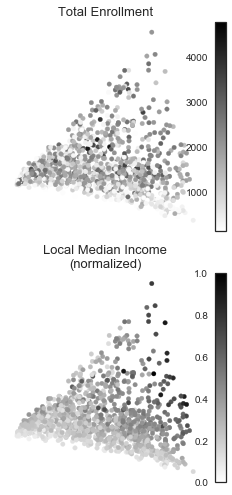

In [575]:
# PCA, colored by total enrollment and median income

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,8))
cmap = 'binary'

# --- ax1 for total enrollment ----
points = ax1.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['totalEnroll'], s=20, cmap=cmap)
f.colorbar(points, ax=ax1)   # color bar for that plot

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('')
ax1.set_title('Total Enrollment', size=13)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# --- ax2 for median income ----
pointsInc = ax2.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['medianIncomeStd_y'], s=20, cmap=cmap)

# plot formatting
ax2.set(xlabel='')
ax2.set_ylabel('')
ax2.set_title('Local Median Income\n(normalized)', size=13)
f.colorbar(pointsInc, ax=ax2)   # color bar for that plot

# figure properties
sns.set(font='Franklin Gothic Book')
ax2.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

# # to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.12, right=0.97)

# save figure
#plt.savefig('PCA_enrollment_And_income.png', dpi=400)

In [576]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,5_y,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType,dropout category
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.513514,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public),0
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.509615,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,State Special Schools,1
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.085714,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,Alternative Schools of Choice,0
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.118743,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,High Schools (Public),0
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.176471,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,K-12 Schools (Public),0


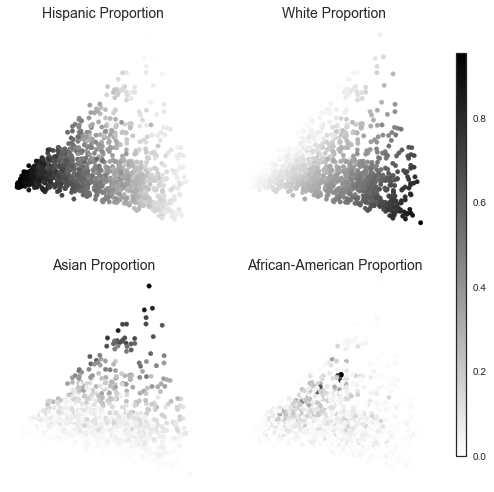

In [577]:
# PCA, colored by ethnicities

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(7,8))

cmap = 'binary'

# --- ax1 for Hispanic proportion ----
points = ax1.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['5_y'], s=20, cmap=cmap)
#f.colorbar(points)

# plot formatting
ax1.set(xlabel='')
ax1.set_ylabel('')
ax1.set_title('Hispanic Proportion', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# --- ax2 for white proportion ----
points = ax2.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['7_y'], s=20, cmap=cmap)
#f.colorbar(points)

# plot formatting
ax2.set(xlabel='')
ax2.set_ylabel('')
ax2.set_title('White Proportion', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax2.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

# --- ax3 for Asian proportion ----
points = ax3.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['2_y'], s=20, cmap=cmap)
#f.colorbar(points)

# plot formatting
ax3.set(xlabel='')
ax3.set_ylabel('')
ax3.set_title('Asian Proportion', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax3.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

# --- ax4 for AA proportion ----
points = ax4.scatter(df_forPCA2['PCAx'], df_forPCA2['PCAy'], c=df_forPCA2['6_y'], s=20, cmap=cmap)
#f.colorbar(points)

# plot formatting
ax4.set(xlabel='')
ax4.set_ylabel('')
ax4.set_title('African-American Proportion', size=14)

# figure properties
sns.set(font='Franklin Gothic Book')
ax4.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# hide x and yaxis and the labels
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.01, right=0.85)

# color bar to span multiple plots
#fig.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
f.colorbar(points, cax=cbar_ax)

# save figure
#plt.savefig('PCA_ethnicities.png', dpi=400)

In [578]:
df_forPCA2['dropout category']

CDSCode
1100170112607     0
1316170131763     1
1611190106401     0
1611190130229     0
1611190130609     0
1611190130625     2
1611190132142     1
1611270130450     0
1611430122697     2
1611430131177     1
1611500132225     0
1611680132746     1
1611760130062     0
1611760130534     2
1611760134270     0
1611760134452     0
1611760135244     0
1611760138693     0
1611920108670     0
1611920113902     0
1611920133629     1
1611920135319     1
1611920138339     2
1612000120931     0
1612000133397     0
1612000134536     0
1612340130054     1
1612420134668     0
1612590100065     0
1612590100701     0
                 ..
56725465631619    0
56725465631742    1
56725465632849    1
56725465634548    0
56725465634761    1
56726035630322    0
56726035635008    1
56726035636188    0
56726525630298    1
56726525630348    0
56726525630793    0
56726525637822    1
56737595630116    0
56737595633748    0
56737595637004    0
56738745630132    0
56739405633250    0
56768285635776    1
577267801195

### Analyze ROIs in PCA

#### Outline ROIs

In [579]:
df_forPCA2[['PCAx', 'PCAy']]

,PCAx,PCAy
CDSCode,,
1100170112607,-0.173482,0.091311
1316170131763,0.040661,0.082117
1611190106401,0.326468,0.546797
1611190130229,0.393392,0.313371
1611190130609,0.371356,0.125610
1611190130625,-0.500479,-0.072972
1611190132142,0.286292,0.264123
1611270130450,0.395628,0.203871
1611430122697,-0.229475,0.072759


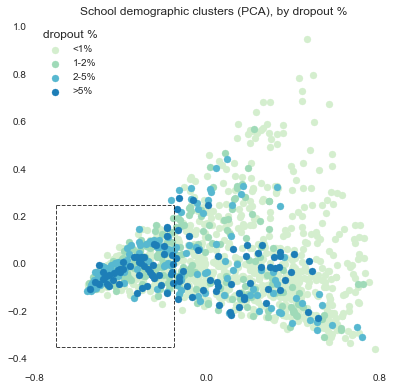

In [581]:
# figure with boxed area

fig, ax1 = plt.subplots(1, figsize=(6,6))

# use an existing color map and apply towards categorical variables
cmap = sns.color_palette("GnBu", 4)

for ind,data in enumerate(df_forPCA2['dropout category'].unique()):
    dfTemp = df_forPCA2[df_forPCA2['dropout category']==data]
    ax1.scatter(x=dfTemp['PCAx'], y=dfTemp['PCAy'], color=cmap[ind])
                #s=dfTemp['feature_z'], color=colors[ind])

# legend formatting
new_labels = ['<1%', '1-2%', '2-5%', '>5%']
ax1.legend(scatterpoints=1, labels=new_labels, title='dropout %', loc='upper left')

# plot the cutoff lines
ax1.plot([-0.7, -0.15], [0.25, 0.25], linewidth=1, linestyle='dashed', color='black', alpha=0.75) # top line
ax1.plot([-0.7, -0.15], [-0.35, -0.35], linewidth=1, linestyle='dashed', color='black', alpha=0.75) # bottom line 
ax1.plot([-0.15, -0.15], [0.25, -0.35], linewidth=1, linestyle='dashed', color='black', alpha=0.75) # right line
ax1.plot([-0.7, -0.7], [0.25, -0.35], linewidth=1, linestyle='dashed', color='black', alpha=0.75) # left line 

# axis labeling
ax1.set(xlabel='', ylabel='')
ax1.set(title='School demographic clusters (PCA), by dropout %')

# figure properties
sns.set(font='Franklin Gothic Book')
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame
plt.xticks((np.arange(-.8, 0.9, 0.8)))

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.12, right=0.95)

# save figure with ROI
#plt.savefig('PCA_byDropoutPerc_wROI.png', dpi=400)

#### Annotate dataframe to indicate schools in boxed region

In [582]:
df_forPCA2['ROIstatus'] = 0
k = df_forPCA2[(df_forPCA2['PCAx'] < -0.15) & (df_forPCA2['PCAy'] > -0.35)].index
df_forPCA2.loc[k,'ROIstatus'] = 1

In [583]:
df_forPCA2.loc[:,'ROIstatus']

CDSCode
1100170112607     1
1316170131763     0
1611190106401     0
1611190130229     0
1611190130609     0
1611190130625     1
1611190132142     0
1611270130450     0
1611430122697     1
1611430131177     0
1611500132225     0
1611680132746     0
1611760130062     0
1611760130534     0
1611760134270     0
1611760134452     0
1611760135244     0
1611760138693     0
1611920108670     1
1611920113902     1
1611920133629     1
1611920135319     0
1611920138339     1
1612000120931     0
1612000133397     0
1612000134536     0
1612340130054     0
1612420134668     0
1612590100065     1
1612590100701     1
                 ..
56725465631619    0
56725465631742    1
56725465632849    1
56725465634548    1
56725465634761    1
56726035630322    0
56726035635008    0
56726035636188    0
56726525630298    0
56726525630348    0
56726525630793    0
56726525637822    0
56737595630116    0
56737595633748    0
56737595637004    0
56738745630132    0
56739405633250    0
56768285635776    1
577267801195

In [584]:
# Randomly chosen schools, regardless of where it is. Same number as ROI.

# gives number for all schools
len(df_forPCA2)

# gives within ROI (522)
# len(df_forPCA2[df_forPCA2['ROIstatus'] == 1])

1334

In [585]:
df_forPCA2['dropout category'].sample(len(df_forPCA2[df_forPCA2['ROIstatus'] == 1]))

CDSCode
31669283136504    0
38684780119875    3
30665483031895    0
19734371931567    1
43696414332904    0
19647331933241    2
19647330112052    2
37683043735974    0
19647330107011    0
10625396112387    3
19647330120360    0
19647331935352    2
19647330126482    3
43696664335949    0
19651361931492    0
37683463737418    0
33103300110833    2
19647330106849    0
19647331937424    2
7617210730457     0
30664643030574    0
40688094036703    0
19647331931526    1
43696664330585    0
19647330114850    3
34673553433471    0
16638911632207    0
36678760109850    0
33670820113159    0
19647330101329    3
                 ..
50710685031521    0
40687594030557    0
34673143430477    1
36676373631066    0
19643371931237    0
34674134835302    0
19647091996313    0
23655992333649    0
34765053433794    1
37681060127241    0
49706564930855    1
34674473432838    2
55724135536750    0
33670823332673    0
27661592733178    1
36676523630571    0
36678763634680    1
33670330110627    0
507573950302

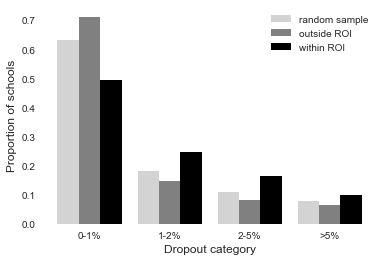

In [586]:
# histograms of dropouts for this selection, compared with others

# side-by-side as a density plot

f, (ax1) = plt.subplots(1, 1, figsize=(6,4))

# to be used for random sampling in ax2 plot
a = df_forPCA2['dropout category'].sample(len(df_forPCA2[df_forPCA2['ROIstatus'] == 1]))

b = df_forPCA2[df_forPCA2['ROIstatus']==0].loc[:,'dropout category']   # outside ROI
c = df_forPCA2[df_forPCA2['ROIstatus']==1].loc[:,'dropout category']   # within ROI

# ax1 plot ------

# a tuple of weights to make the heights of the bars sum to 1 in each group
myHistWeights = (np.ones_like(a)/float(len(a)), np.ones_like(b)/float(len(b)), np.ones_like(c)/float(len(c)))

ax1.hist((a, b, c), 4, label=('random sample', 'outside ROI', 'within ROI'),
         color=('#d3d3d3', 'gray', 'black'), weights=myHistWeights, normed=False);
ax1.legend()

# relabel x-axis
plt.xticks([0.75/2, 0.75*2-(0.75/2), 0.75*3-(0.75/2), 0.75*4-(0.75/2)])
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['0-1%', '1-2%', '2-5%', '>5%']
ax1.set_xticklabels(labels)
#ax1.set_ylim(0,1)  # change y-axis limit

# control labels
# ax1.set_title('', size=14)
ax1.set_xlabel('Dropout category', size=12)
ax1.set_ylabel('Proportion of schools', size=12)

# figure properties
sns.set(font='Franklin Gothic Book')
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# save plot
#plt.savefig('DropoutCategory_hist.png', dpi=400)

### Boxplots for different features

In [587]:
df_forPCA2.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,6_y,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType,dropout category,ROIstatus
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.383292,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public),0,1
1316170131763,4.0,1.442308,89874.0,0.0,1.0,12.0,1.0,11.0,106.0,22.0,...,0.105769,0.240385,0.024038,0.447878,0.040661,0.082117,208.0,State Special Schools,1,0
1611190106401,8.2,0.000000,72884.0,0.0,0.0,102.0,4.0,21.0,15.0,7.0,...,0.040000,0.125714,0.022857,0.349132,0.326468,0.546797,175.0,Alternative Schools of Choice,0,0
1611190130229,8.2,0.232829,72884.0,1.0,3.0,693.0,13.0,91.0,204.0,112.0,...,0.065192,0.310827,0.038999,0.349132,0.393392,0.313371,1718.0,High Schools (Public),0,0
1611190130609,8.2,0.490196,72884.0,2.0,1.0,37.0,0.0,11.0,36.0,21.0,...,0.102941,0.382353,0.088235,0.349132,0.371356,0.125610,204.0,K-12 Schools (Public),0,0


### Statistical tests

In [588]:
from scipy.stats import ttest_ind

# dataframe by categories to setup grouping
df_outsideROI = df_forPCA2[df_forPCA2['ROIstatus']==0]
df_insideROI= df_forPCA2[df_forPCA2['ROIstatus']==1]

# total enrollment
print('Total enrollment: ', ttest_ind(df_outsideROI['totalEnroll'], df_insideROI['totalEnroll']))

# median income
print('Median income: ', ttest_ind(df_outsideROI['medianIncome'], df_insideROI['medianIncome']))

# % below poverty line
print('% below poverty line: ', ttest_ind(df_outsideROI['percFamilyBelowPovertyLevel'], df_insideROI['percFamilyBelowPovertyLevel']))

# Hispanic proportion
print('Hispanic proportion: ', ttest_ind(df_outsideROI['5_y'], df_insideROI['5_y']))

Total enrollment:  Ttest_indResult(statistic=2.4893285539803998, pvalue=0.012919734943627094)
Median income:  Ttest_indResult(statistic=18.516291387448558, pvalue=2.7171368032395746e-68)
% below poverty line:  Ttest_indResult(statistic=-23.443820131755029, pvalue=4.8835330193133317e-102)
Hispanic proportion:  Ttest_indResult(statistic=-55.398163153348776, pvalue=0.0)


In [589]:
# create a function to output the t-test result to be used in plot labeling

def printTTestResult(df1, df2, parameter):
    test, p = ttest_ind(df1[parameter], df2[parameter])
    if p < 0.000001:
        p_forPlot = 'p < 0.0000001'
    else:
        p_forPlot = 'p = '+"{0:.3f}".format(p)
    return(p_forPlot)

#Test the function
printTTestResult(df_outsideROI, df_insideROI, 'totalEnroll')


'p = 0.013'

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


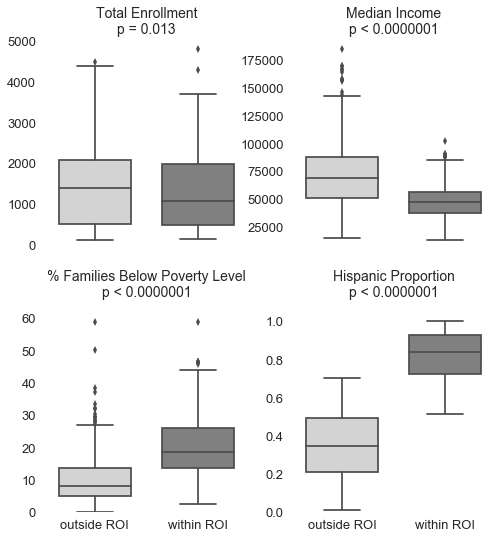

In [591]:
# Show boxplots for total enrollment, median income, % below poverty line, Hispanic proportion

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,8), sharex=True);

# ------------------ ax1 ---------------
sns.boxplot(x='ROIstatus', y='totalEnroll', data=df_forPCA2,
            palette=('#d3d3d3', 'gray'),
            width=0.7, ax=ax1);   # hex value for light gray, order=xorder, 

# plot formatting
ax1.set(xlabel='', ylabel='')
ax1.set_title('Total Enrollment\n'+printTTestResult(df_outsideROI, df_insideROI, 'totalEnroll'), size=14)   # add statistical test result to title
ax1.tick_params(labelsize=13)

# ------------------ ax2 ---------------
sns.boxplot(x='ROIstatus', y='medianIncome', data=df_forPCA2,
            palette=('#d3d3d3', 'gray'),
            width=0.7, ax=ax2);   # hex value for light gray, order=xorder, 

# plot formatting
ax2.set(xlabel='', ylabel='')
ax2.set_title('Median Income\n'+printTTestResult(df_outsideROI, df_insideROI, 'medianIncome'), size=14)   # add statistical test result to title
ax2.tick_params(labelsize=13)

# ------------------ ax3 ---------------
sns.boxplot(x='ROIstatus', y='percFamilyBelowPovertyLevel', data=df_forPCA2,
            palette=('#d3d3d3', 'gray'),
            width=0.7, ax=ax3);   # hex value for light gray, order=xorder, 

# plot formatting
ax3.set(xlabel='', ylabel='')
ax3.set_title('% Families Below Poverty Level\n'+printTTestResult(df_outsideROI, df_insideROI, 'percFamilyBelowPovertyLevel'), size=14)   # add statistical test result to title
ax3.set_ylim(0, 65)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax3.set_xticklabels(labels, fontsize=12)
ax3.tick_params(labelsize=13)

# ------------------ ax4 ---------------
sns.boxplot(x='ROIstatus', y='5_y', data=df_forPCA2,
            palette=('#d3d3d3', 'gray'),
            width=0.7, ax=ax4);   # hex value for light gray, order=xorder, 

# plot formatting
ax4.set(xlabel='', ylabel='')
ax4.set_title('Hispanic Proportion\n'+printTTestResult(df_outsideROI, df_insideROI, '5_y'), size=14)   # add statistical test result to title
ax4.set_ylim(0, 1.1)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax4.set_xticklabels(labels, fontsize=12)
ax4.tick_params(labelsize=13)

# ------------figure properties-------------
sns.set(font='Franklin Gothic Book')
# ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.92, left=0.1, right=1, hspace=0.25)

# save figure
plt.savefig('Boxplots_Out_v_withinROI.png', dpi=400)

### Analysis 3: Identification of overperforming schools

#### Things to evaluate within the ROI
Confirm that previously evaluated metrics are the same


In [592]:
# create a marker for low and high dropout categories in a new column
df_insideROI.loc[:,'withinROI_DOstatus'] = 0   

k = df_insideROI[df_insideROI['dropout category'] < 1].index
df_insideROI.loc[k,'withinROI_DOstatus'] = 'low'

ki = df_insideROI[df_insideROI['dropout category'] > 1].index
df_insideROI.loc[ki,'withinROI_DOstatus'] = 'high'


/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [594]:
# new dataframe for the A/B analysis purpose
df_insideROI_ab = df_insideROI[df_insideROI['withinROI_DOstatus'] != 0]

# dfs based on category to be used in statistical tests
df_insideROI_a = df_insideROI_ab[df_insideROI_ab['withinROI_DOstatus']=='low']
df_insideROI_b = df_insideROI_ab[df_insideROI_ab['withinROI_DOstatus']=='high']

In [595]:
print('No. of schools with low dropouts: ', len(df_insideROI_ab[df_insideROI_ab['withinROI_DOstatus']=='low']))
print('No. of schools with high dropouts: ', len(df_insideROI_ab[df_insideROI_ab['withinROI_DOstatus']=='high']))

No. of schools with low dropouts:  258
No. of schools with high dropouts:  136


In [596]:
# statistical test

# total enrollment
print('Total enrollment: ', ttest_ind(df_insideROI_a['totalEnroll'], df_insideROI_b['totalEnroll']))

# median income
print('Median income: ', ttest_ind(df_insideROI_a['medianIncome'], df_insideROI_b['medianIncome']))

# % below poverty line
print('% below poverty line: ', ttest_ind(df_insideROI_a['percFamilyBelowPovertyLevel'], df_insideROI_b['percFamilyBelowPovertyLevel']))

# Hispanic proportion
print('Hispanic proportion: ', ttest_ind(df_insideROI_a['5_y'], df_insideROI_b['5_y']))


Total enrollment:  Ttest_indResult(statistic=2.5196277938926244, pvalue=0.012144517514550746)
Median income:  Ttest_indResult(statistic=2.816851356506938, pvalue=0.005094967520247449)
% below poverty line:  Ttest_indResult(statistic=-3.1636795626147238, pvalue=0.0016793584081269744)
Hispanic proportion:  Ttest_indResult(statistic=2.1490250252508458, pvalue=0.032244155685451803)


/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


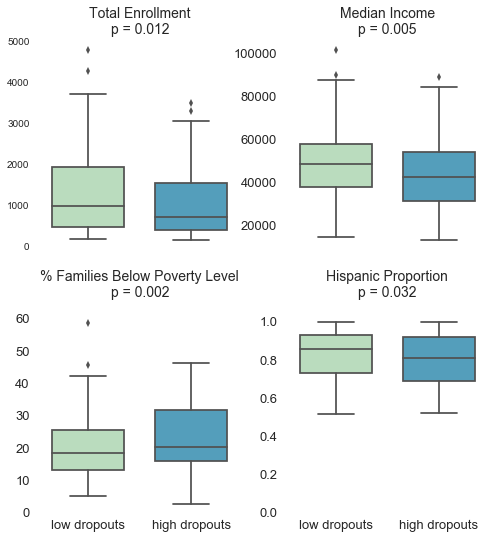

In [597]:
# Show boxplots for total enrollment, median income, % below poverty line, Hispanic proportion
# compare within the ROI

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,8), sharex=True);

# use similar colors I used before to denote dropout
# cmap = sns.color_palette("GnBu", 4)
my_cmap = sns.color_palette("GnBu", 2)

# ------------------ ax1 ---------------
sns.boxplot(x='withinROI_DOstatus', y='totalEnroll', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax1);   # hex value for light gray, order=xorder, 

# plot formatting
ax1.set(xlabel='', ylabel='')
ax1.set_title('Total Enrollment\n'+printTTestResult(df_insideROI_a, df_insideROI_b,
            'totalEnroll'), size=14)   # add statistical test result to title
#ax1.tick_params(labelsize=13)

# ------------------ ax2 ---------------
sns.boxplot(x='withinROI_DOstatus', y='medianIncome', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax2);   # hex value for light gray, order=xorder, 

# plot formatting
ax2.set(xlabel='', ylabel='')
ax2.set_title('Median Income\n'+printTTestResult(df_insideROI_a, df_insideROI_b,
                'medianIncome'), size=14)   # add statistical test result to title
ax2.tick_params(labelsize=13)

# ------------------ ax3 ---------------
sns.boxplot(x='withinROI_DOstatus', y='percFamilyBelowPovertyLevel', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax3);   # hex value for light gray, order=xorder, 

# plot formatting
ax3.set(xlabel='', ylabel='')
ax3.set_title('% Families Below Poverty Level\n'+printTTestResult(df_insideROI_a, df_insideROI_b,
                'percFamilyBelowPovertyLevel'), size=14)   # add statistical test result to title
ax3.set_ylim(0, 65)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax3.set_xticklabels(labels, fontsize=12)
ax3.tick_params(labelsize=13)

# ------------------ ax4 ---------------
sns.boxplot(x='withinROI_DOstatus', y='5_y', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax4);   # hex value for light gray, order=xorder, 

# plot formatting
ax4.set(xlabel='', ylabel='')
ax4.set_title('Hispanic Proportion\n'+printTTestResult(df_insideROI_a, df_insideROI_b, '5_y'), size=14)   # add statistical test result to title
ax4.set_ylim(0, 1.1)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['low dropouts', 'high dropouts']
ax4.set_xticklabels(labels, fontsize=12)
ax4.tick_params(labelsize=13)

# ------------figure properties-------------
sns.set(font='Franklin Gothic Book')
# ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.92, left=0.1, right=1, hspace=0.25)

# save figure
plt.savefig('Boxplots_withinROIcomparison.png', dpi=400)

In [598]:
df_insideROI_ab.head()

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,7_y,9_y,medianIncomeStd_y,PCAx,PCAy,totalEnroll,SOCType,dropout category,ROIstatus,withinROI_DOstatus
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,14.5,0.491400,32993.0,8.0,5.0,7.0,3.0,1.0,209.0,156.0,...,0.031941,0.012285,0.117286,-0.173482,0.091311,407.0,High Schools (Public),0,1,low
1611190130625,30.9,4.242424,31903.0,1.0,0.0,0.0,0.0,1.0,153.0,9.0,...,0.006061,0.000000,0.110951,-0.500479,-0.072972,165.0,High Schools (Public),2,1,high
1611430122697,13.4,4.098361,56995.0,5.0,0.0,4.0,1.0,2.0,236.0,80.0,...,0.043716,0.060109,0.256786,-0.229475,0.072759,366.0,High Schools (Public),2,1,high
1611920108670,6.9,0.187617,76773.0,15.0,0.0,58.0,15.0,39.0,362.0,24.0,...,0.020638,0.016886,0.371735,-0.230771,0.161661,533.0,High Schools (Public),0,1,low
1611920113902,6.9,0.865801,76773.0,5.0,1.0,14.0,13.0,26.0,307.0,61.0,...,0.047619,0.028139,0.371735,-0.212835,0.113710,462.0,High Schools (Public),0,1,low


In [599]:
# Merge dfPS with the df_insideROI_ab
df_insideROI_ab_wChar = pd.merge(df_insideROI_ab, dfPS, how='left', left_index=True, right_on='CDSCode')

In [600]:
df_insideROI_ab_wChar.columns

Index(['percFamilyBelowPovertyLevel', 'dropout %', 'medianIncome', '0_x',
       '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '9_x',
       'medianIncomeStd_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
       '7_y', '9_y', 'medianIncomeStd_y', 'PCAx', 'PCAy', 'totalEnroll',
       'SOCType_x', 'dropout category', 'ROIstatus', 'withinROI_DOstatus',
       'CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'Website', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType_y', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'AdmFName1', 'AdmLName1',
       'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2', 'AdmFName3',
       'AdmLName3', 'AdmEmail3', 'LastUpdate', 

#### Identify socio-economic features that separate low dropouts from high dropouts

In [609]:
df_insideROI_ab_wCharSE = pd.merge(df_insideROI_ab_wChar, df_dem2, how='inner', left_on='ZipSimple', right_index=True)

In [610]:
# dfs based on category to be used in statistical tests
df_insideROI_wCharSE_a = df_insideROI_ab_wCharSE[df_insideROI_ab_wCharSE['withinROI_DOstatus']=='low']
df_insideROI_wCharSE_b = df_insideROI_ab_wCharSE[df_insideROI_ab_wCharSE['withinROI_DOstatus']=='high']

In [620]:
df_insideROI_ab_wCharSE.columns[70:100]

Index(['AdmLName1', 'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2',
       'AdmFName3', 'AdmLName3', 'AdmEmail3', 'LastUpdate', 'ZipSimple',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Employed',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Unemployed',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Armed Forces',
       'Percent; EMPLOYMENT STATUS - Population 16 years and over - Not in labor force',
       'Percent; EMPLOYMENT STATUS - Civilian labor force',
       'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate',
       'Percent; EMPLOYME

In [624]:
# Confine dataframe to features of interest
dfTemp = df_insideROI_ab_wCharSE.loc[:,'Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force':]

In [625]:
dfTemp.head()

,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Employed,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Unemployed,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Armed Forces,Percent; EMPLOYMENT STATUS - Population 16 years and over - Not in labor force,Percent; EMPLOYMENT STATUS - Civilian labor force,Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate,Percent; EMPLOYMENT STATUS - Females 16 years and over,Percent; EMPLOYMENT STATUS - Females 16 years and over - In labor force,...,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
2,62.7,62.4,55.6,6.8,0.3,37.3,8506,11,6513,54.6,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
56,61.4,61.4,52.1,9.4,0,38.6,14515,15.2,12242,53.4,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
418,61.4,61.4,52.1,9.4,0,38.6,14515,15.2,12242,53.4,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
438,61.4,61.4,52.1,9.4,0,38.6,14515,15.2,12242,53.4,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
103,75.4,75,67.7,7.3,0.4,24.6,4121,9.7,2828,69.6,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [626]:
# Make a dataframe for feature and p-value

df_ImpFeatures = pd.DataFrame()

df_ImpFeatures['feature'] = None
df_ImpFeatures['feature_pVal'] = None

count = 0
columnsToModifyLater = []
for ind, data in dfTemp.iteritems():
    try:
        df_ImpFeatures.loc[count, 'feature'] = ind
        df_ImpFeatures.loc[count, 'feature_pVal'] = ttest_ind(df_insideROI_wCharSE_a[ind], df_insideROI_wCharSE_b[ind]).pvalue
        count=count+1
    except:
        #continue
        columnsToModifyLater.append(ind)
        

df_ImpFeatures.sort_values(by='feature_pVal')

/Users/lacar/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,feature,feature_pVal
67,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.75801e-09
68,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.81163e-08
37,Estimate; COMMUTING TO WORK - Workers 16 years...,3.14161e-07
94,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.02481e-06
10,Percent; INCOME AND BENEFITS (IN 2015 INFLATIO...,1.02481e-06
84,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,2.80368e-06
69,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,3.01136e-06
85,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.7387e-05
64,Estimate; CLASS OF WORKER - Civilian employed ...,7.30753e-05
54,Estimate; INDUSTRY - Civilian employed populat...,0.000116074


In [627]:
df_ImpFeatures2 = df_ImpFeatures.sort_values(by='feature_pVal')

In [634]:
df_ImpFeatures2['feature_pVal']

67     1.75801e-09
68     1.81163e-08
37     3.14161e-07
94     1.02481e-06
10     1.02481e-06
84     2.80368e-06
69     3.01136e-06
85      1.7387e-05
64     7.30753e-05
54     0.000116074
80     0.000127416
86     0.000162253
70     0.000199222
81     0.000501332
38     0.000647629
82      0.00105993
108      0.0017032
117     0.00178597
48      0.00211268
8       0.00271031
66      0.00271031
107     0.00290734
59      0.00293904
99      0.00414872
71      0.00537194
56      0.00616016
77      0.00763158
112     0.00827582
58      0.00839976
40        0.009214
          ...     
44        0.199551
24        0.199795
63        0.203719
96        0.211472
3         0.239642
32        0.239642
92        0.282925
76        0.290678
57        0.330025
45        0.360444
65        0.382489
78        0.383819
105       0.418404
33        0.454253
93         0.51425
51        0.522754
55        0.561359
74         0.56513
79        0.577179
36        0.581622
35         0.59976
116       0.

In [636]:
import statsmodels.stats.multitest as smm
rej, pval_corr = smm.multipletests(df_ImpFeatures2['feature_pVal'], method='b')[:2]

In [640]:
df_ImpFeatures2['reject'] = rej
df_ImpFeatures2['feature_pVal_corr'] = pval_corr

In [667]:
df_ImpFeatures2.iloc[:13,]

,feature,feature_pVal,reject,feature_pVal_corr
67,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.75801e-09,True,2.10962e-07
68,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.81163e-08,True,2.17395e-06
37,Estimate; COMMUTING TO WORK - Workers 16 years...,3.14161e-07,True,3.76994e-05
94,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.02481e-06,True,0.000122977
10,Percent; INCOME AND BENEFITS (IN 2015 INFLATIO...,1.02481e-06,True,0.000122977
84,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,2.80368e-06,True,0.000336441
69,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,3.01136e-06,True,0.000361364
85,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.7387e-05,True,0.00208644
64,Estimate; CLASS OF WORKER - Civilian employed ...,7.30753e-05,True,0.00876903
54,Estimate; INDUSTRY - Civilian employed populat...,0.000116074,True,0.0139289


In [655]:
count=0
for i in df_ImpFeatures2['feature']:
    print(count, i)
    count=count+1

0 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000
1 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - $10,000 to $14,999
2 Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)
3 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Nonfamily households
4 Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Nonfamily households
5 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - Less than $10,000
6 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - $15,000 to $24,999
7 Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - $10,000 to $14,999
8 Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Self-employed in own not incorporated business workers
9 Estimate; INDUSTRY - Civilian employed population 16

In [668]:
#feature1 = 'Estimate; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000'
feature1 = 'Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)'
feature2 = 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Nonfamily households'
# feature3 = 'Estimate; INDUSTRY - Civilian employed population 16 years and over - Information'
# feature4 = 'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population 18 to 64 years - In labor force: - Employed: - With health insurance coverage - With public coverage'

/Users/lacar/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


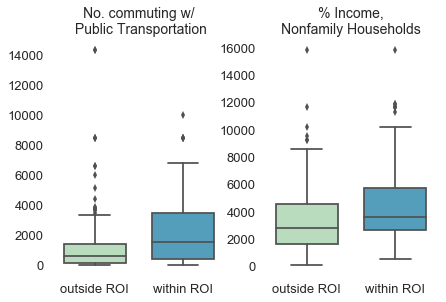

In [676]:
# Show boxplots for total enrollment, median income, % below poverty line, Hispanic proportion
# compare within the ROI

#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,8), sharex=True);
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,4))  #  , sharex=True);

# use similar colors I used before to denote dropout
# cmap = sns.color_palette("GnBu", 4)
my_cmap = sns.color_palette("GnBu", 2)

# ------------------ ax1 ---------------
sns.boxplot(x='withinROI_DOstatus', y=feature1, data=df_insideROI_ab_wCharSE,
            palette=my_cmap,
            width=0.7, ax=ax1);   # hex value for light gray, order=xorder, 

# plot formatting
ax1.set(xlabel='', ylabel='')
ax1.set_title('No. commuting w/\n Public Transportation', size=14)
#ax1.tick_params(labelsize=13)

# re-set xtick labels
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax1.set_xticklabels(labels, fontsize=12)
ax1.tick_params(labelsize=13)

# ------------------ ax2 ---------------
sns.boxplot(x='withinROI_DOstatus', y=feature2, data=df_insideROI_ab_wCharSE,
            palette=my_cmap,
            width=0.7, ax=ax2);   # hex value for light gray, order=xorder, 

# plot formatting
ax2.set(xlabel='', ylabel='')
ax2.set_title('% Income,\nNonfamily Households', size=14)
#ax1.tick_params(labelsize=13)

# re-set xtick labels
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax2.set_xticklabels(labels, fontsize=12)
ax2.tick_params(labelsize=13)

# ------------figure properties-------------
sns.set(font='Franklin Gothic Book')
# ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.92, left=0.1, right=1, hspace=0.25)

# save figure
# plt.savefig('Boxplots_withinROIcomparison.png', dpi=400)

### Does magnet or charter status make a difference?

In [268]:
# determine the percentage that are charter between the two.
print('Proportion of low dropout schools that are charters: ',
      len(dfTemp[(dfTemp['withinROI_DOstatus']=='low') & (dfTemp['Charter']=='Y')]) /
      len(dfTemp[dfTemp['withinROI_DOstatus']=='low']))

print('Proportion of high dropout schools that are charters: ',
      len(dfTemp[(dfTemp['withinROI_DOstatus']=='high') & (dfTemp['Charter']=='Y')]) /
      len(dfTemp[dfTemp['withinROI_DOstatus']=='high']))

Proportion of low dropout schools that are charters:  0.29069767441860467
Proportion of high dropout schools that are charters:  0.25


In [265]:
# determine the percentage that are magnets between the two.
print('Proportion of low dropout schools that are magnet schools: ',
      len(dfTemp[(dfTemp['withinROI_DOstatus']=='low') & (dfTemp['Magnet']=='Y')]) /
      len(dfTemp[dfTemp['withinROI_DOstatus']=='low']))

print('Proportion of high dropout schools that are magnet schools: ',
      len(dfTemp[(dfTemp['withinROI_DOstatus']=='high') & (dfTemp['Magnet']=='Y')]) /
      len(dfTemp[dfTemp['withinROI_DOstatus']=='high']))

Proportion of low dropout schools that are magnet schools:  0.07364341085271318
Proportion of high dropout schools that are magnet schools:  0.15441176470588236


### Find the outlier schools within low dropout group

In [601]:
# confine dataframe to low dropout group
dfTemp = df_insideROI_ab_wChar[df_insideROI_ab_wChar['withinROI_DOstatus']=='low']

In [602]:
dfTemp.columns

Index(['percFamilyBelowPovertyLevel', 'dropout %', 'medianIncome', '0_x',
       '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '9_x',
       'medianIncomeStd_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
       '7_y', '9_y', 'medianIncomeStd_y', 'PCAx', 'PCAy', 'totalEnroll',
       'SOCType_x', 'dropout category', 'ROIstatus', 'withinROI_DOstatus',
       'CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'Website', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType_y', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'AdmFName1', 'AdmLName1',
       'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2', 'AdmFName3',
       'AdmLName3', 'AdmEmail3', 'LastUpdate', 

In [603]:
# sort based on percentage of families below poverty line

colOfInterest = ['percFamilyBelowPovertyLevel', 'dropout %', 'medianIncome',
                 '0_y', '1_y', '2_y', '3_y', '4_y', '5_y','6_y', '7_y', '9_y',
                 'totalEnroll', 'SOCType_x', 'CDSCode', 'NCESDist', 'NCESSchool', 'StatusType',
                 'County', 'District', 'School', 'City', 'Zip', 'Charter', 'CharterNum', 'FundingType']

dfOutliers = dfTemp.sort_values(by='percFamilyBelowPovertyLevel', ascending=False)[colOfInterest]

In [604]:
dfOutliers.iloc[:5,:]  #.to_csv('OutlierSchools.csv')

,percFamilyBelowPovertyLevel,dropout %,medianIncome,0_y,1_y,2_y,3_y,4_y,5_y,6_y,...,NCESSchool,StatusType,County,District,School,City,Zip,Charter,CharterNum,FundingType
13576,58.7,0.421941,14579.0,0.008439,0.004219,0.059072,0.004219,0.050633,0.628692,0.054852,...,12547.0,Active,San Joaquin,Stockton Unified,Stockton Collegiate International Secondary,Stockton,95202-2906,Y,1143,Directly funded
2056,45.7,0.000000,26800.0,0.000000,0.000000,0.007924,0.000000,0.000000,0.982567,0.000000,...,10782.0,Active,Fresno,Kings Canyon Joint Unified,Orange Cove High,Orange Cove,93646-2374,N,NaN,NaN
4909,42.2,0.970874,30251.0,0.001618,0.001618,0.000000,0.000000,0.000000,0.990291,0.004854,...,11635.0,Active,Los Angeles,Los Angeles Unified,Animo Ralph Bunche Charter High,Los Angeles,90011-2202,Y,0781,Directly funded
5114,42.2,0.515464,30251.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.974227,0.022337,...,12883.0,Active,Los Angeles,Los Angeles Unified,Synergy Quantum Academy,Los Angeles,90011-4522,Y,1299,Directly funded
4943,42.2,0.000000,30251.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.980545,0.019455,...,12035.0,Closed,Los Angeles,Los Angeles Unified,Student Empowerment Academy,Los Angeles,90011-3301,Y,1582,Directly funded


## May not do this anymore

Evaluate the folowing

- Charter
- FundingType
- SOCType
- EdOpsName (like SOCType)
- Magnet

In [ ]:
# Or look at the median income spreadsheet

In [267]:
dfTemp = df_insideROI_ab_wChar[['withinROI_DOstatus', 'Charter']]

In [231]:
# Funding type - too many NaNs?
# df_insideROI_ab_wChar['FundingType']

2        Directly funded
56       Directly funded
103      Directly funded
233      Directly funded
235      Directly funded
248                  NaN
393      Directly funded
396                  NaN
418      Directly funded
438                  NaN
446      Directly funded
455                  NaN
457      Directly funded
467                  NaN
468                  NaN
500      Directly funded
1070                 NaN
1082                 NaN
1089     Directly funded
1389     Directly funded
1419                 NaN
1421                 NaN
1835                 NaN
1855                 NaN
1867                 NaN
1893                 NaN
1905                 NaN
1909                 NaN
1910                 NaN
2055                 NaN
              ...       
14758                NaN
14826                NaN
15042    Directly funded
15050                NaN
15055                NaN
15317                NaN
15320    Directly funded
16160    Directly funded
16197                NaN


In [282]:
# determine the breakdown for all of these
df_insideROI_ab_wChar[df_insideROI_ab_wChar['withinROI_DOstatus']=='low'].groupby('SOCType_y')['dropout %'].agg([np.mean, 'count'])

,mean,count
SOCType_y,,
Alternative Schools of Choice,0.238195,12
Elementary Schools (Public),1.000000,1
High Schools (Public),0.419029,220
K-12 Schools (Public),0.331256,24
Opportunity Schools,0.179211,1


In [283]:
# determine the breakdown for all of these
df_insideROI_ab_wChar[df_insideROI_ab_wChar['withinROI_DOstatus']=='high'].groupby('SOCType_y')['dropout %'].agg([np.mean, 'count'])

,mean,count
SOCType_y,,
Alternative Schools of Choice,25.220794,8
Continuation High Schools,28.166667,2
County Community,21.031839,6
District Community Day Schools,17.567568,1
High Schools (Public),6.874986,101
Juvenile Court Schools,52.206491,2
K-12 Schools (Public),10.983071,14
Opportunity Schools,24.736842,1
Special Education Schools (Public),16.113744,1


In [263]:
dfTemp = df_insideROI_ab_wChar[['withinROI_DOstatus', 'Magnet']]

### Look at stats only for public schools

In [286]:
# determine the breakdown for all of these
df_insideROI_ab_wChar_PS = df_insideROI_ab_wChar[df_insideROI_ab_wChar['SOCType_y']=='High Schools (Public)']

In [291]:
df_insideROI_ab_wChar_PS.columns

Index(['percFamilyBelowPovertyLevel', 'dropout %', 'medianIncome', '0_x',
       '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '9_x',
       'medianIncomeStd_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y',
       '7_y', '9_y', 'medianIncomeStd_y', 'PCAx', 'PCAy', 'totalEnroll',
       'SOCType_x', 'dropout category', 'ROIstatus', 'withinROI_DOstatus',
       'CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'Website', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType_y', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'AdmFName1', 'AdmLName1',
       'AdmEmail1', 'AdmFName2', 'AdmLName2', 'AdmEmail2', 'AdmFName3',
       'AdmLName3', 'AdmEmail3', 'LastUpdate', 

In [292]:
# statistical test

# new dataframe for the A/B analysis purpose

# dfs based on category to be used in statistical tests
df_insideROI_ab_wChar_PS_a = df_insideROI_ab_wChar_PS[df_insideROI_ab_wChar_PS['withinROI_DOstatus']=='low']
df_insideROI_ab_wChar_PS_b = df_insideROI_ab_wChar_PS[df_insideROI_ab_wChar_PS['withinROI_DOstatus']=='high']

# total enrollment
print('Total enrollment: ', ttest_ind(df_insideROI_ab_wChar_PS_a['totalEnroll'], df_insideROI_ab_wChar_PS_b['totalEnroll']))

# median income
print('Median income: ', ttest_ind(df_insideROI_ab_wChar_PS_a['medianIncome'], df_insideROI_ab_wChar_PS_b['medianIncome']))

# % below poverty line
print('% below poverty line: ', ttest_ind(df_insideROI_ab_wChar_PS_a['percFamilyBelowPovertyLevel'], df_insideROI_ab_wChar_PS_b['percFamilyBelowPovertyLevel']))

# Hispanic proportion
print('Hispanic proportion: ', ttest_ind(df_insideROI_ab_wChar_PS_a['5_y'], df_insideROI_ab_wChar_PS_b['5_y']))


Total enrollment:  Ttest_indResult(statistic=1.8095715045003502, pvalue=0.071303365183403106)
Median income:  Ttest_indResult(statistic=3.7592930616180311, pvalue=0.00020262198157123626)
% below poverty line:  Ttest_indResult(statistic=-4.1024416195335061, pvalue=5.1952230766622404e-05)
Hispanic proportion:  Ttest_indResult(statistic=0.95896502992728105, pvalue=0.33830260811317137)


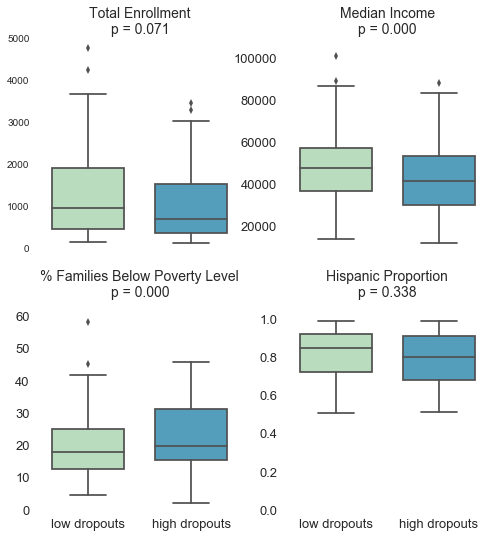

In [295]:
# Show boxplots for total enrollment, median income, % below poverty line, Hispanic proportion
# compare within the ROI

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,8), sharex=True);

# use similar colors I used before to denote dropout
# cmap = sns.color_palette("GnBu", 4)
my_cmap = sns.color_palette("GnBu", 2)

# ------------------ ax1 ---------------
sns.boxplot(x='withinROI_DOstatus', y='totalEnroll', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax1);   # hex value for light gray, order=xorder, 

# plot formatting
ax1.set(xlabel='', ylabel='')
ax1.set_title('Total Enrollment\n'+printTTestResult(df_insideROI_ab_wChar_PS_a, df_insideROI_ab_wChar_PS_b,
            'totalEnroll'), size=14)   # add statistical test result to title
#ax1.tick_params(labelsize=13)

# ------------------ ax2 ---------------
sns.boxplot(x='withinROI_DOstatus', y='medianIncome', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax2);   # hex value for light gray, order=xorder, 

# plot formatting
ax2.set(xlabel='', ylabel='')
ax2.set_title('Median Income\n'+printTTestResult(df_insideROI_ab_wChar_PS_a, df_insideROI_ab_wChar_PS_b,
                'medianIncome'), size=14)   # add statistical test result to title
ax2.tick_params(labelsize=13)

# ------------------ ax3 ---------------
sns.boxplot(x='withinROI_DOstatus', y='percFamilyBelowPovertyLevel', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax3);   # hex value for light gray, order=xorder, 

# plot formatting
ax3.set(xlabel='', ylabel='')
ax3.set_title('% Families Below Poverty Level\n'+printTTestResult(df_insideROI_ab_wChar_PS_a, df_insideROI_ab_wChar_PS_b,
                'percFamilyBelowPovertyLevel'), size=14)   # add statistical test result to title
ax3.set_ylim(0, 65)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['outside ROI', 'within ROI']
ax3.set_xticklabels(labels, fontsize=12)
ax3.tick_params(labelsize=13)

# ------------------ ax4 ---------------
sns.boxplot(x='withinROI_DOstatus', y='5_y', data=df_insideROI_ab,
            palette=my_cmap,
            width=0.7, ax=ax4);   # hex value for light gray, order=xorder, 

# plot formatting
ax4.set(xlabel='', ylabel='')
ax4.set_title('Hispanic Proportion\n'+printTTestResult(df_insideROI_ab_wChar_PS_a, df_insideROI_ab_wChar_PS_b,
                '5_y'), size=14)   # add statistical test result to title
ax4.set_ylim(0, 1.1)

# re-set xtick labels
labels = [item.get_text() for item in ax3.get_xticklabels()]
labels = ['low dropouts', 'high dropouts']
ax4.set_xticklabels(labels, fontsize=12)
ax4.tick_params(labelsize=13)

# ------------figure properties-------------
sns.set(font='Franklin Gothic Book')
# ax1.tick_params(axis='both', which='both',length=0)   # remove tick marks
sns.set_style(style='white')
sns.despine(left=True, bottom=True, right=True)   #  remove frame

# to accomodate labeling
plt.subplots_adjust(bottom=0.1, top=0.92, left=0.1, right=1, hspace=0.25)

# save figure
#plt.savefig('Boxplots_withinROIcomparison.png', dpi=400)

In [677]:
# Finding features of overperforming schools

In [414]:
df_dem.head()

,Id,Geography,Estimate; EMPLOYMENT STATUS - Population 16 years and over,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Percent; EMPLOYMENT STATUS - Population 16 years and over,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,...,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,percFamilyBelowPovertyLevel,medianIncome
Id2,,,,,,,,,,,,,,,,,,,,,
89010,8600000US89010,ZCTA5 89010,484,125,484,(X),233,92,48.1,12.9,...,(X),(X),21.2,16.2,(X),(X),39.1,23.2,21.4,35625
89019,8600000US89019,ZCTA5 89019,1663,527,1663,(X),852,310,51.2,13.3,...,(X),(X),0,2.2,(X),(X),24.9,16.8,0,38134
89046,8600000US89046,ZCTA5 89046,404,136,404,(X),175,96,43.3,13.9,...,(X),(X),41,34,(X),(X),40.1,20.6,19.8,26667
89060,8600000US89060,ZCTA5 89060,8136,629,8136,(X),3473,514,42.7,4.9,...,(X),(X),18.5,6.9,(X),(X),23.9,6.2,13.6,40700
89061,8600000US89061,ZCTA5 89061,4492,529,4492,(X),1889,340,42.1,5.1,...,(X),(X),3.2,3,(X),(X),18.2,11.8,3.5,54708


In [ ]:
# merge on zip code

In [415]:
# Find all the columns that have percentages or raw numbers that we can evaluate.
# They start with 'Percent;' and 'Estimate;'  Make a distinction between them before filtering out weird columns.

filterColPercent1 = [col for col in df_dem if col.startswith('Percent;')]
filterColEstimate1 =[col for col in df_dem if col.startswith('Estimate;')]
filter_colAll_1 = filterColPercent1 + filterColEstimate1

In [416]:
# Create a new demograpic dataframe that only has the columns of interest
df_dem2 = df_dem[filter_colAll_1]


In [417]:
print('No. of demographic features by zip code, before feature filtering: ', len(df_dem2.columns))


No. of demographic features by zip code, before feature filtering:  274


In [418]:
# test stats for DF as is
from scipy.stats import ttest_ind

# MOCK SETUP 

# dataframe by categories to setup grouping
df_test1 = df_dem2[df_dem2['Estimate; EMPLOYMENT STATUS - Population 16 years and over'] > 4000]
df_test2 = df_dem2[df_dem2['Estimate; EMPLOYMENT STATUS - Population 16 years and over'] < 4000]


In [430]:
# Make a dataframe for feature and p-value

df_ImpFeatures = pd.DataFrame()

In [433]:
df_ImpFeatures['feature'] = None
df_ImpFeatures['feature_pVal'] = None

In [437]:
# Make a dataframe for feature and p-value

df_ImpFeatures = pd.DataFrame()

df_ImpFeatures['feature'] = None
df_ImpFeatures['feature_pVal'] = None

count = 0
columnsToModifyLater = []
for ind, data in df_dem4.iteritems():
    try:
        df_ImpFeatures.loc[count, 'feature'] = ind
        df_ImpFeatures.loc[count, 'feature_pVal'] = ttest_ind(df_test1[ind], df_test2[ind]).pvalue
        count=count+1
    except:
        #continue
        columnsToModifyLater.append(ind)
        

df_ImpFeatures.sort_values(by='feature_pVal')

/Users/lacar/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [436]:
df_ImpFeatures.sort_values(by='feature_pVal')

,feature,feature_pVal
67,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,1.14906e-300
9,Percent; INCOME AND BENEFITS (IN 2015 INFLATIO...,1.14906e-300
78,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,9.82319e-288
97,Estimate; HEALTH INSURANCE COVERAGE - Civilian...,3.72358e-279
79,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,3.01085e-276
19,Estimate; EMPLOYMENT STATUS - Population 16 ye...,4.91033e-276
0,Percent; EMPLOYMENT STATUS - Population 16 yea...,4.91033e-276
84,Estimate; INCOME AND BENEFITS (IN 2015 INFLATI...,7.71082e-276
10,Percent; INCOME AND BENEFITS (IN 2015 INFLATIO...,7.71082e-276
27,Estimate; EMPLOYMENT STATUS - Females 16 years...,2.62288e-274


In [455]:
# look at remaining columns
df_dem4[columnsToModifyLater].head()

KeyError: "[ 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Total households - Median household income (dollars)'\n 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Families - Median family income (dollars)'\n 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Nonfamily households - Median nonfamily income (dollars)'\n 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Median earnings for workers (dollars)'\n 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Median earnings for male full-time, year-round workers (dollars)'\n 'Percent; INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS) - Median earnings for female full-time, year-round workers (dollars)'\n 'Estimate; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All families'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All families - With related children of the householder under 18 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All families - With related children of the householder under 18 years - With related children of the householder under 5 years only'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families - With related children of the householder under 18 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families - With related children of the householder under 18 years - With related children of the householder under 5 years only'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present - With related children of the householder under 18 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present - With related children of the householder under 18 years - With related children of the householder under 5 years only'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder under 5 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Under 18 years - Related children of the householder under 18 years - Related children of the householder 5 to 17 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 years and over'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 18 to 64 years'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families'\n 'Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over'] not in index"

In [451]:
# drop columns that have a lot of '(X)'
nunique = df_dem4.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_dem4.drop(cols_to_drop, axis=1, inplace=True)

In [453]:
# drop the weird row index 96155
# df_dem4.drop(96155, axis=0, inplace=True)


In [ ]:
# Redo stats loop

# Initiate the count for the next one to index
count2 = count+1

for ind, data in df_dem4[columnsToModifyLater].iteritems():
    try:
        df_ImpFeatures.loc[count, 'feature'] = ind
        df_ImpFeatures.loc[count, 'feature_pVal'] = ttest_ind(df_test1[ind], df_test2[ind]).pvalue
        count=count+1
    except:
        #continue
        columnsToModifyLater.append(ind)

In [442]:
?pd.DataFrame.drop

In [ ]:
# k = (dfInfoAllBySchoolw25['medianIncome']=='(X)') | (dfInfoAllBySchoolw25['medianIncome']=='-') 

In [ ]:
# print('Test stat: ', ttest_ind(df_test1['Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force'], df_test2['Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force']))

statsTestsTemp = []
statsIndTests = []

count=0

for ind, data in df_dem4.iteritems():
    #print(ind)
    #print(data)
    try:
        #statsTestsTemp.append(data[df_test1.index])
        #statsTestsTemp = ttest_ind(df_test1[ind], df_test2[ind])
        statsIndTests.append(ind + ' -- ' + str(ttest_ind(df_test1[ind], df_test2[ind]).pvalue))
        count=count+1
    except:
        columnsToModifyLater.append(ind)

print(len(columnsToModifyLater))
print(count)

df_dem4[columnsToModifyLater[0]]   # has a NaN
df_dem4[columnsToModifyLater[2]]   # has a NaN


# delete any rows that are only NaN
ttest_ind(df_test1[ind], df_test2[ind]) 

df_dem2.iloc[filterColEstimate1]


?pd.DataFrame.all()

# Dataframe update so that '(X)' or '(-)' are converted to NaN and overall DF are numeric values
df_dem4 = df_dem3.convert_objects(convert_numeric=True)

for ind, data in df_dem2.iteritems():
    k = (df_dem3[ind]=='(X)') | (df_dem3[ind]=='-') 
    df_dem3.loc[k,ind] = pd.to_numeric(df_dem3.loc[k,ind], errors='coerce')

    
# remove weird row with median income value - 250,000+
df_dem3 = df_dem2[df_dem2['medianIncome'] != '250,000+']


# convert '(X)' to NaN
k = (df_dem4[ind]=='(X)') | (df_dem4[ind]=='-') 
df_dem4.loc[k,ind] = pd.to_numeric(df_dem4.loc[k,ind], errors='coerce')



# this should still be a string
df_dem3.head().iloc[0,3]

# sanity check that row was removed
print('shape before and after row removal: ', df_dem2.shape, df_dem3.shape)

# Remove columns with unexplained percentages above 100

# get overview of data
df_dem4.head().max(axis=0)

# End of study